# Digits generator

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Reshape, Flatten
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import UpSampling2D, Conv2DTranspose, Conv2D

from keras.optimizers import SGD, RMSprop

Using TensorFlow backend.


## Data

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


## Visualisation

In [4]:
def reshape_image(pixels):
    npix = int(np.sqrt(pixels.shape[0]))
    return np.reshape(pixels, (npix, npix))

def draw_image(image):
    image = np.reshape(image, (image.shape[0], image.shape[1]))
    plt.imshow(image, cmap = plt.get_cmap('gray'))
    plt.axis('off')
    plt.show()

In [5]:
# draw_image(reshape_image(mnist.train.images[0]))

In [6]:
X_train = mnist.train.images.reshape(-1,  
                                     28, 
                                     28, 
                                     1).astype(np.float32)
y_train = mnist.train.labels

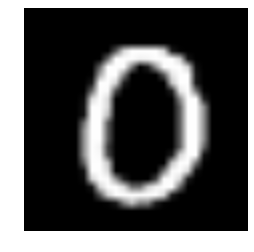

(None, array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]))

In [7]:
draw_image(X_train[10]), y_train[10]

In [8]:
X_train.shape

(55000, 28, 28, 1)

# GAN example
## Generator

In [9]:
gen_dropout = 0.3
gen_input_dim = 7
gen_depth = 256
gen_noise_dim = 100

In [10]:
gennet = Sequential()

# Input 
# fully-connected layer
gennet.add(Dense(gen_input_dim * gen_input_dim * gen_depth, 
                 input_dim=gen_noise_dim))
gennet.add(BatchNormalization(momentum=0.9))
gennet.add(Activation('relu'))
gennet.add(Reshape((gen_input_dim, gen_input_dim, gen_depth)))
gennet.add(Dropout(gen_dropout))

# Deconvolution layers
gennet.add(UpSampling2D())
gennet.add(Conv2DTranspose(int(gen_depth / 2), 5, padding='same'))
gennet.add(BatchNormalization(momentum=0.9))
gennet.add(Activation('relu'))

gennet.add(UpSampling2D())
gennet.add(Conv2DTranspose(int(gen_depth / 4), 5, padding='same'))
gennet.add(BatchNormalization(momentum=0.9))
gennet.add(Activation('relu'))

gennet.add(Conv2DTranspose(int(gen_depth / 8), 5, padding='same'))
gennet.add(BatchNormalization(momentum=0.9))
gennet.add(Activation('relu'))

# Output
gennet.add(Conv2DTranspose(1, 5, padding='same'))
gennet.add(Activation('sigmoid'))

gennet.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 12544)             1266944   
_________________________________________________________________
batch_normalization_1 (Batch (None, 12544)             50176     
_________________________________________________________________
activation_1 (Activation)    (None, 12544)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 256)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 256)         0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 14, 14, 256)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 128)       819328    
__________

## Discriminator

In [11]:
disc_depth = 64
disc_dropout = 0.3

In [12]:
discnet = Sequential()

# Input
discnet.add(Conv2D(disc_depth, 5, strides=2, input_shape=(28, 28, 1), 
                   padding='same'))
discnet.add(Activation('relu'))
discnet.add(Dropout(disc_dropout))

discnet.add(Conv2D(disc_depth*2, 5, strides=2, padding='same'))
discnet.add(Activation('relu'))
discnet.add(Dropout(disc_dropout))

discnet.add(Conv2D(disc_depth*4, 5, strides=2, padding='same'))
discnet.add(Activation('relu'))
discnet.add(Dropout(disc_dropout))

discnet.add(Conv2D(disc_depth*8, 5, strides=2, padding='same'))
discnet.add(Activation('relu'))
discnet.add(Dropout(disc_dropout))

# Out: scalar estimation of probability
discnet.add(Flatten())
discnet.add(Dense(1))
discnet.add(Activation('sigmoid'))

discnet.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
activation_6 (Activation)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
activation_7 (Activation)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 256)         819456    
__________

## Discriminator model

In [13]:
discmodel = Sequential()
discmodel.add(discnet)
discmodel.compile(loss='binary_crossentropy', 
                  optimizer=RMSprop(lr=0.0002, clipvalue=1.0, decay=6e-8),
                  metrics=['accuracy'])

## Adversarial model

In [14]:
advmodel = Sequential()
advmodel.add(gennet)
advmodel.add(discnet)
advmodel.compile(loss='binary_crossentropy', 
                 optimizer=RMSprop(lr=0.0001, clipvalue=1.0, decay=3e-8),
                 metrics=['accuracy'])

## Training

In [ ]:
batch_size = 256
train_iters = 10000

disc_losses = {"loss": [], "acc": []}
adv_losses = {"loss": [], "acc": []}

for i in range(train_iters):
    # Get random real images
    images_true = X_train[np.random.randint(0, 
                                            X_train.shape[0], 
                                            size=batch_size)]
    # Generate images from noise
    noise = np.random.uniform(-1.0, 1.0, 
                              size=[batch_size, gen_noise_dim])
    images_fake = gennet.predict(noise)
    # Compose training data for discriminator
    x = np.concatenate((images_true, images_fake))
    y = np.concatenate((np.ones((batch_size, 1)), 
                        np.zeros((batch_size, 1))))
    # Train discriminator on composed data
    dics_loss = discmodel.train_on_batch(x, y)
    disc_losses["loss"].append(dics_loss[0])
    disc_losses["acc"].append(dics_loss[1])
    
    # Compose trainig data for adversarial net
    noise = np.random.uniform(-1.0, 1.0, 
                              size=[batch_size, gen_noise_dim])
    y = np.ones([batch_size, 1])
    # Train adversarial net on composed data
    adv_loss = advmodel.train_on_batch(noise, y)
    adv_losses["loss"].append(adv_loss[0])
    adv_losses["acc"].append(adv_loss[1])
    
    # Print results
    print("{}th batch of {} |Disc loss {} |Disc acc {} |Adv loss {} |Adv acc {}".format(i+1, train_iters,
                                                                                       dics_loss[0], dics_loss[1], 
                                                                                       adv_loss[0], adv_loss[1]))

1th batch of 10000 |Disc loss 0.6964483261108398 |Disc acc 0.375 |Adv loss 0.8426675796508789 |Adv acc 0.0
2th batch of 10000 |Disc loss 0.6636546850204468 |Disc acc 0.5 |Adv loss 0.7853949069976807 |Adv acc 0.0
3th batch of 10000 |Disc loss 0.5773411393165588 |Disc acc 0.5 |Adv loss 0.9401605129241943 |Adv acc 0.0
4th batch of 10000 |Disc loss 0.44900545477867126 |Disc acc 1.0 |Adv loss 0.1424989104270935 |Adv acc 1.0
5th batch of 10000 |Disc loss 1.4593993425369263 |Disc acc 0.5 |Adv loss 1.2369571924209595 |Adv acc 0.0
6th batch of 10000 |Disc loss 0.25664210319519043 |Disc acc 1.0 |Adv loss 0.30890902876853943 |Adv acc 1.0
7th batch of 10000 |Disc loss 0.31011176109313965 |Disc acc 0.990234375 |Adv loss 0.1631600558757782 |Adv acc 1.0
8th batch of 10000 |Disc loss 0.27216288447380066 |Disc acc 1.0 |Adv loss 0.12490817159414291 |Adv acc 1.0
9th batch of 10000 |Disc loss 0.2512362003326416 |Disc acc 1.0 |Adv loss 0.05837856978178024 |Adv acc 1.0
10th batch of 10000 |Disc loss 0.20333

74th batch of 10000 |Disc loss 0.2936106026172638 |Disc acc 0.927734375 |Adv loss 1.0414754152297974 |Adv acc 0.25
75th batch of 10000 |Disc loss 0.6304901838302612 |Disc acc 0.611328125 |Adv loss 3.8392696380615234 |Adv acc 0.0
76th batch of 10000 |Disc loss 0.3157670497894287 |Disc acc 0.90625 |Adv loss 0.8577612638473511 |Adv acc 0.37109375
77th batch of 10000 |Disc loss 0.6208040118217468 |Disc acc 0.630859375 |Adv loss 3.374054193496704 |Adv acc 0.0
78th batch of 10000 |Disc loss 0.2695845365524292 |Disc acc 0.947265625 |Adv loss 1.0874658823013306 |Adv acc 0.19140625
79th batch of 10000 |Disc loss 0.5359147787094116 |Disc acc 0.64453125 |Adv loss 3.2686901092529297 |Adv acc 0.0
80th batch of 10000 |Disc loss 0.28788596391677856 |Disc acc 0.927734375 |Adv loss 0.8950003385543823 |Adv acc 0.37109375
81th batch of 10000 |Disc loss 0.5741344094276428 |Disc acc 0.62109375 |Adv loss 3.1702582836151123 |Adv acc 0.0
82th batch of 10000 |Disc loss 0.3321859538555145 |Disc acc 0.90234375 |

145th batch of 10000 |Disc loss 0.7135066390037537 |Disc acc 0.498046875 |Adv loss 1.619041919708252 |Adv acc 0.0
146th batch of 10000 |Disc loss 0.5915631055831909 |Disc acc 0.79296875 |Adv loss 0.6602877974510193 |Adv acc 0.61328125
147th batch of 10000 |Disc loss 0.7269179821014404 |Disc acc 0.5 |Adv loss 1.6191303730010986 |Adv acc 0.0
148th batch of 10000 |Disc loss 0.577629566192627 |Disc acc 0.78515625 |Adv loss 0.6775541305541992 |Adv acc 0.55078125
149th batch of 10000 |Disc loss 0.6966347694396973 |Disc acc 0.501953125 |Adv loss 1.429964542388916 |Adv acc 0.0
150th batch of 10000 |Disc loss 0.587323009967804 |Disc acc 0.814453125 |Adv loss 0.7495306730270386 |Adv acc 0.35546875
151th batch of 10000 |Disc loss 0.6826754808425903 |Disc acc 0.5 |Adv loss 1.484175682067871 |Adv acc 0.0
152th batch of 10000 |Disc loss 0.5688408017158508 |Disc acc 0.84765625 |Adv loss 0.7473064064979553 |Adv acc 0.3671875
153th batch of 10000 |Disc loss 0.687463641166687 |Disc acc 0.5 |Adv loss 1.5

216th batch of 10000 |Disc loss 0.5756844282150269 |Disc acc 0.81640625 |Adv loss 0.7623082399368286 |Adv acc 0.39453125
217th batch of 10000 |Disc loss 0.7402777075767517 |Disc acc 0.5078125 |Adv loss 2.1765735149383545 |Adv acc 0.0
218th batch of 10000 |Disc loss 0.715721070766449 |Disc acc 0.501953125 |Adv loss 0.5418230295181274 |Adv acc 0.87109375
219th batch of 10000 |Disc loss 0.7784168720245361 |Disc acc 0.501953125 |Adv loss 1.2441351413726807 |Adv acc 0.0
220th batch of 10000 |Disc loss 0.6022054553031921 |Disc acc 0.755859375 |Adv loss 0.7741972208023071 |Adv acc 0.30078125
221th batch of 10000 |Disc loss 0.6471868753433228 |Disc acc 0.513671875 |Adv loss 1.0821971893310547 |Adv acc 0.0
222th batch of 10000 |Disc loss 0.5886666774749756 |Disc acc 0.724609375 |Adv loss 0.9282459020614624 |Adv acc 0.078125
223th batch of 10000 |Disc loss 0.6136913895606995 |Disc acc 0.595703125 |Adv loss 1.1401362419128418 |Adv acc 0.0
224th batch of 10000 |Disc loss 0.5900578498840332 |Disc a

287th batch of 10000 |Disc loss 0.6869340538978577 |Disc acc 0.51953125 |Adv loss 1.263134241104126 |Adv acc 0.00390625
288th batch of 10000 |Disc loss 0.6365234851837158 |Disc acc 0.685546875 |Adv loss 0.7279263734817505 |Adv acc 0.4296875
289th batch of 10000 |Disc loss 0.7042031288146973 |Disc acc 0.515625 |Adv loss 1.2969565391540527 |Adv acc 0.0
290th batch of 10000 |Disc loss 0.6363927721977234 |Disc acc 0.6953125 |Adv loss 0.7088618874549866 |Adv acc 0.5234375
291th batch of 10000 |Disc loss 0.7239691615104675 |Disc acc 0.515625 |Adv loss 1.3815758228302002 |Adv acc 0.0
292th batch of 10000 |Disc loss 0.6332597732543945 |Disc acc 0.66015625 |Adv loss 0.6319562792778015 |Adv acc 0.65625
293th batch of 10000 |Disc loss 0.7244830131530762 |Disc acc 0.5 |Adv loss 1.2916420698165894 |Adv acc 0.0
294th batch of 10000 |Disc loss 0.6342257261276245 |Disc acc 0.71484375 |Adv loss 0.7303107380867004 |Adv acc 0.39453125
295th batch of 10000 |Disc loss 0.6976452469825745 |Disc acc 0.5117187

357th batch of 10000 |Disc loss 0.7058250904083252 |Disc acc 0.513671875 |Adv loss 1.2713702917099 |Adv acc 0.0
358th batch of 10000 |Disc loss 0.6487095355987549 |Disc acc 0.619140625 |Adv loss 0.6797882914543152 |Adv acc 0.57421875
359th batch of 10000 |Disc loss 0.6934101581573486 |Disc acc 0.51953125 |Adv loss 1.165900468826294 |Adv acc 0.0078125
360th batch of 10000 |Disc loss 0.6501436233520508 |Disc acc 0.6328125 |Adv loss 0.6942366361618042 |Adv acc 0.5
361th batch of 10000 |Disc loss 0.6928858160972595 |Disc acc 0.515625 |Adv loss 1.1887766122817993 |Adv acc 0.0078125
362th batch of 10000 |Disc loss 0.6477972269058228 |Disc acc 0.64453125 |Adv loss 0.6995057463645935 |Adv acc 0.5
363th batch of 10000 |Disc loss 0.6890795826911926 |Disc acc 0.521484375 |Adv loss 1.1634070873260498 |Adv acc 0.0078125
364th batch of 10000 |Disc loss 0.6532739400863647 |Disc acc 0.6171875 |Adv loss 0.762811541557312 |Adv acc 0.3984375
365th batch of 10000 |Disc loss 0.6804074048995972 |Disc acc 0.

426th batch of 10000 |Disc loss 0.6513257026672363 |Disc acc 0.634765625 |Adv loss 0.7806737422943115 |Adv acc 0.28125
427th batch of 10000 |Disc loss 0.6817452311515808 |Disc acc 0.5390625 |Adv loss 0.9981585741043091 |Adv acc 0.01171875
428th batch of 10000 |Disc loss 0.6585449576377869 |Disc acc 0.638671875 |Adv loss 0.7976956367492676 |Adv acc 0.2421875
429th batch of 10000 |Disc loss 0.6761231422424316 |Disc acc 0.53515625 |Adv loss 1.1064410209655762 |Adv acc 0.01171875
430th batch of 10000 |Disc loss 0.6695294976234436 |Disc acc 0.6015625 |Adv loss 0.7545881867408752 |Adv acc 0.35546875
431th batch of 10000 |Disc loss 0.6859866976737976 |Disc acc 0.525390625 |Adv loss 1.127596139907837 |Adv acc 0.015625
432th batch of 10000 |Disc loss 0.6539196968078613 |Disc acc 0.642578125 |Adv loss 0.6562020778656006 |Adv acc 0.6640625
433th batch of 10000 |Disc loss 0.7234072089195251 |Disc acc 0.498046875 |Adv loss 1.2664529085159302 |Adv acc 0.0
434th batch of 10000 |Disc loss 0.6766656041

495th batch of 10000 |Disc loss 0.6907957792282104 |Disc acc 0.525390625 |Adv loss 1.116178035736084 |Adv acc 0.00390625
496th batch of 10000 |Disc loss 0.6572498083114624 |Disc acc 0.62109375 |Adv loss 0.7004169821739197 |Adv acc 0.48828125
497th batch of 10000 |Disc loss 0.7071682810783386 |Disc acc 0.513671875 |Adv loss 1.1532303094863892 |Adv acc 0.0
498th batch of 10000 |Disc loss 0.6699461936950684 |Disc acc 0.5859375 |Adv loss 0.7004622220993042 |Adv acc 0.46484375
499th batch of 10000 |Disc loss 0.6956957578659058 |Disc acc 0.505859375 |Adv loss 1.0226479768753052 |Adv acc 0.015625
500th batch of 10000 |Disc loss 0.6537457704544067 |Disc acc 0.6328125 |Adv loss 0.7410665154457092 |Adv acc 0.34375
501th batch of 10000 |Disc loss 0.6805649995803833 |Disc acc 0.53125 |Adv loss 1.0390952825546265 |Adv acc 0.01953125
502th batch of 10000 |Disc loss 0.6519887447357178 |Disc acc 0.640625 |Adv loss 0.7306378483772278 |Adv acc 0.42578125
503th batch of 10000 |Disc loss 0.686224579811096

564th batch of 10000 |Disc loss 0.6529473066329956 |Disc acc 0.638671875 |Adv loss 0.8209612369537354 |Adv acc 0.22265625
565th batch of 10000 |Disc loss 0.6648150682449341 |Disc acc 0.546875 |Adv loss 0.9893547296524048 |Adv acc 0.03125
566th batch of 10000 |Disc loss 0.6525339484214783 |Disc acc 0.607421875 |Adv loss 0.8622203469276428 |Adv acc 0.1640625
567th batch of 10000 |Disc loss 0.6553683876991272 |Disc acc 0.587890625 |Adv loss 0.9725044965744019 |Adv acc 0.0625
568th batch of 10000 |Disc loss 0.6520620584487915 |Disc acc 0.623046875 |Adv loss 0.9578477144241333 |Adv acc 0.0703125
569th batch of 10000 |Disc loss 0.6414992809295654 |Disc acc 0.638671875 |Adv loss 0.9476256370544434 |Adv acc 0.07421875
570th batch of 10000 |Disc loss 0.6579428315162659 |Disc acc 0.619140625 |Adv loss 1.0273492336273193 |Adv acc 0.05078125
571th batch of 10000 |Disc loss 0.6483389735221863 |Disc acc 0.626953125 |Adv loss 0.90946364402771 |Adv acc 0.109375
572th batch of 10000 |Disc loss 0.654908

633th batch of 10000 |Disc loss 0.6517413854598999 |Disc acc 0.62109375 |Adv loss 0.9756349325180054 |Adv acc 0.08984375
634th batch of 10000 |Disc loss 0.6556357145309448 |Disc acc 0.58984375 |Adv loss 0.9419347643852234 |Adv acc 0.10546875
635th batch of 10000 |Disc loss 0.6533455848693848 |Disc acc 0.607421875 |Adv loss 0.966836154460907 |Adv acc 0.06640625
636th batch of 10000 |Disc loss 0.6508477330207825 |Disc acc 0.615234375 |Adv loss 0.9892625212669373 |Adv acc 0.06640625
637th batch of 10000 |Disc loss 0.6516015529632568 |Disc acc 0.607421875 |Adv loss 1.0264787673950195 |Adv acc 0.0625
638th batch of 10000 |Disc loss 0.6339662671089172 |Disc acc 0.6328125 |Adv loss 0.9861489534378052 |Adv acc 0.0625
639th batch of 10000 |Disc loss 0.6516768336296082 |Disc acc 0.62109375 |Adv loss 1.0179427862167358 |Adv acc 0.05859375
640th batch of 10000 |Disc loss 0.6473333835601807 |Disc acc 0.615234375 |Adv loss 0.9990268349647522 |Adv acc 0.08203125
641th batch of 10000 |Disc loss 0.6559

702th batch of 10000 |Disc loss 0.6371126770973206 |Disc acc 0.634765625 |Adv loss 0.8902248740196228 |Adv acc 0.203125
703th batch of 10000 |Disc loss 0.67304927110672 |Disc acc 0.587890625 |Adv loss 1.1863459348678589 |Adv acc 0.0234375
704th batch of 10000 |Disc loss 0.6480241417884827 |Disc acc 0.634765625 |Adv loss 0.7031658291816711 |Adv acc 0.4921875
705th batch of 10000 |Disc loss 0.730961263179779 |Disc acc 0.51953125 |Adv loss 1.4322154521942139 |Adv acc 0.0
706th batch of 10000 |Disc loss 0.6867368221282959 |Disc acc 0.54296875 |Adv loss 0.6277420520782471 |Adv acc 0.59375
707th batch of 10000 |Disc loss 0.730903685092926 |Disc acc 0.51171875 |Adv loss 1.066636323928833 |Adv acc 0.0390625
708th batch of 10000 |Disc loss 0.6342018246650696 |Disc acc 0.673828125 |Adv loss 0.7744818925857544 |Adv acc 0.34765625
709th batch of 10000 |Disc loss 0.6605522036552429 |Disc acc 0.5625 |Adv loss 0.9678568840026855 |Adv acc 0.08203125
710th batch of 10000 |Disc loss 0.6468098759651184 |

771th batch of 10000 |Disc loss 0.6868895292282104 |Disc acc 0.5234375 |Adv loss 1.2276651859283447 |Adv acc 0.00390625
772th batch of 10000 |Disc loss 0.6632857322692871 |Disc acc 0.5859375 |Adv loss 0.6874188184738159 |Adv acc 0.54296875
773th batch of 10000 |Disc loss 0.6832071542739868 |Disc acc 0.533203125 |Adv loss 1.1163537502288818 |Adv acc 0.0234375
774th batch of 10000 |Disc loss 0.6494104862213135 |Disc acc 0.62890625 |Adv loss 0.7695608139038086 |Adv acc 0.328125
775th batch of 10000 |Disc loss 0.6663675308227539 |Disc acc 0.568359375 |Adv loss 1.0352627038955688 |Adv acc 0.046875
776th batch of 10000 |Disc loss 0.619430661201477 |Disc acc 0.6953125 |Adv loss 0.8536801338195801 |Adv acc 0.22265625
777th batch of 10000 |Disc loss 0.6792004108428955 |Disc acc 0.57421875 |Adv loss 1.1263033151626587 |Adv acc 0.02734375
778th batch of 10000 |Disc loss 0.6335389614105225 |Disc acc 0.669921875 |Adv loss 0.7849999666213989 |Adv acc 0.32421875
779th batch of 10000 |Disc loss 0.6749

840th batch of 10000 |Disc loss 0.6545248031616211 |Disc acc 0.61328125 |Adv loss 0.7191649675369263 |Adv acc 0.47265625
841th batch of 10000 |Disc loss 0.6739983558654785 |Disc acc 0.556640625 |Adv loss 1.1469337940216064 |Adv acc 0.01953125
842th batch of 10000 |Disc loss 0.6541810035705566 |Disc acc 0.603515625 |Adv loss 0.7817301750183105 |Adv acc 0.3984375
843th batch of 10000 |Disc loss 0.6647048592567444 |Disc acc 0.57421875 |Adv loss 1.1212772130966187 |Adv acc 0.03125
844th batch of 10000 |Disc loss 0.6247161626815796 |Disc acc 0.677734375 |Adv loss 0.8463424444198608 |Adv acc 0.2421875
845th batch of 10000 |Disc loss 0.6381638050079346 |Disc acc 0.625 |Adv loss 1.093982219696045 |Adv acc 0.03515625
846th batch of 10000 |Disc loss 0.6391475200653076 |Disc acc 0.626953125 |Adv loss 0.8368929028511047 |Adv acc 0.24609375
847th batch of 10000 |Disc loss 0.655978262424469 |Disc acc 0.61328125 |Adv loss 1.1493966579437256 |Adv acc 0.02734375
848th batch of 10000 |Disc loss 0.641166

909th batch of 10000 |Disc loss 0.6497132182121277 |Disc acc 0.61328125 |Adv loss 1.0271304845809937 |Adv acc 0.1015625
910th batch of 10000 |Disc loss 0.6480898857116699 |Disc acc 0.625 |Adv loss 0.8631548285484314 |Adv acc 0.2578125
911th batch of 10000 |Disc loss 0.638360857963562 |Disc acc 0.62109375 |Adv loss 1.0838117599487305 |Adv acc 0.05078125
912th batch of 10000 |Disc loss 0.6451743245124817 |Disc acc 0.6328125 |Adv loss 0.8600839376449585 |Adv acc 0.26953125
913th batch of 10000 |Disc loss 0.6691515445709229 |Disc acc 0.611328125 |Adv loss 1.186371088027954 |Adv acc 0.06640625
914th batch of 10000 |Disc loss 0.6457974314689636 |Disc acc 0.62890625 |Adv loss 0.8069687485694885 |Adv acc 0.34765625
915th batch of 10000 |Disc loss 0.6618288159370422 |Disc acc 0.59375 |Adv loss 1.2158756256103516 |Adv acc 0.03125
916th batch of 10000 |Disc loss 0.6468349695205688 |Disc acc 0.611328125 |Adv loss 0.7602771520614624 |Adv acc 0.39453125
917th batch of 10000 |Disc loss 0.657317638397

978th batch of 10000 |Disc loss 0.637637734413147 |Disc acc 0.6171875 |Adv loss 1.2168676853179932 |Adv acc 0.03515625
979th batch of 10000 |Disc loss 0.637240469455719 |Disc acc 0.609375 |Adv loss 0.7784117460250854 |Adv acc 0.3671875
980th batch of 10000 |Disc loss 0.6879129409790039 |Disc acc 0.56640625 |Adv loss 1.2853429317474365 |Adv acc 0.0078125
981th batch of 10000 |Disc loss 0.6303430795669556 |Disc acc 0.650390625 |Adv loss 0.7208328247070312 |Adv acc 0.51171875
982th batch of 10000 |Disc loss 0.6994559168815613 |Disc acc 0.5625 |Adv loss 1.310200572013855 |Adv acc 0.015625
983th batch of 10000 |Disc loss 0.6490418910980225 |Disc acc 0.626953125 |Adv loss 0.7081896662712097 |Adv acc 0.5546875
984th batch of 10000 |Disc loss 0.6925478577613831 |Disc acc 0.548828125 |Adv loss 1.2282644510269165 |Adv acc 0.0234375
985th batch of 10000 |Disc loss 0.6476612687110901 |Disc acc 0.609375 |Adv loss 0.7831132411956787 |Adv acc 0.37890625
986th batch of 10000 |Disc loss 0.6706257462501

1047th batch of 10000 |Disc loss 0.6444101929664612 |Disc acc 0.634765625 |Adv loss 0.7125194668769836 |Adv acc 0.52734375
1048th batch of 10000 |Disc loss 0.6887761354446411 |Disc acc 0.5625 |Adv loss 1.1823135614395142 |Adv acc 0.0234375
1049th batch of 10000 |Disc loss 0.6274138689041138 |Disc acc 0.66796875 |Adv loss 0.7865908145904541 |Adv acc 0.3828125
1050th batch of 10000 |Disc loss 0.6716909408569336 |Disc acc 0.5625 |Adv loss 1.089827537536621 |Adv acc 0.046875
1051th batch of 10000 |Disc loss 0.6331967115402222 |Disc acc 0.62890625 |Adv loss 0.8477525115013123 |Adv acc 0.26171875
1052th batch of 10000 |Disc loss 0.7028917074203491 |Disc acc 0.546875 |Adv loss 1.1614370346069336 |Adv acc 0.03515625
1053th batch of 10000 |Disc loss 0.6516640186309814 |Disc acc 0.62109375 |Adv loss 0.8101730942726135 |Adv acc 0.3203125
1054th batch of 10000 |Disc loss 0.6459764242172241 |Disc acc 0.619140625 |Adv loss 1.1074737310409546 |Adv acc 0.0625
1055th batch of 10000 |Disc loss 0.6212376

1116th batch of 10000 |Disc loss 0.6236700415611267 |Disc acc 0.66796875 |Adv loss 0.7366896271705627 |Adv acc 0.453125
1117th batch of 10000 |Disc loss 0.7049713730812073 |Disc acc 0.54296875 |Adv loss 1.3556405305862427 |Adv acc 0.01171875
1118th batch of 10000 |Disc loss 0.6467387676239014 |Disc acc 0.59375 |Adv loss 0.6376217603683472 |Adv acc 0.65625
1119th batch of 10000 |Disc loss 0.7285317182540894 |Disc acc 0.5390625 |Adv loss 1.2538954019546509 |Adv acc 0.0234375
1120th batch of 10000 |Disc loss 0.6466002464294434 |Disc acc 0.6015625 |Adv loss 0.732780396938324 |Adv acc 0.453125
1121th batch of 10000 |Disc loss 0.7045239806175232 |Disc acc 0.5625 |Adv loss 1.1956002712249756 |Adv acc 0.03125
1122th batch of 10000 |Disc loss 0.6302615404129028 |Disc acc 0.64453125 |Adv loss 0.838869035243988 |Adv acc 0.27734375
1123th batch of 10000 |Disc loss 0.6660710573196411 |Disc acc 0.595703125 |Adv loss 1.0085968971252441 |Adv acc 0.12109375
1124th batch of 10000 |Disc loss 0.6357784867

1184th batch of 10000 |Disc loss 0.6659533381462097 |Disc acc 0.59765625 |Adv loss 1.1775333881378174 |Adv acc 0.05859375
1185th batch of 10000 |Disc loss 0.6371271014213562 |Disc acc 0.64453125 |Adv loss 0.8209563493728638 |Adv acc 0.3203125
1186th batch of 10000 |Disc loss 0.6802899837493896 |Disc acc 0.591796875 |Adv loss 1.2698209285736084 |Adv acc 0.015625
1187th batch of 10000 |Disc loss 0.6562383770942688 |Disc acc 0.591796875 |Adv loss 0.6919466257095337 |Adv acc 0.5625
1188th batch of 10000 |Disc loss 0.7135442495346069 |Disc acc 0.541015625 |Adv loss 1.257995367050171 |Adv acc 0.01953125
1189th batch of 10000 |Disc loss 0.6522635221481323 |Disc acc 0.6015625 |Adv loss 0.7527137994766235 |Adv acc 0.4140625
1190th batch of 10000 |Disc loss 0.6746910214424133 |Disc acc 0.5546875 |Adv loss 1.110754370689392 |Adv acc 0.04296875
1191th batch of 10000 |Disc loss 0.6546239852905273 |Disc acc 0.63671875 |Adv loss 0.8769865036010742 |Adv acc 0.19921875
1192th batch of 10000 |Disc loss 

1253th batch of 10000 |Disc loss 0.6331061124801636 |Disc acc 0.64453125 |Adv loss 0.7785096168518066 |Adv acc 0.41015625
1254th batch of 10000 |Disc loss 0.7041674256324768 |Disc acc 0.560546875 |Adv loss 1.1638596057891846 |Adv acc 0.01171875
1255th batch of 10000 |Disc loss 0.6705864667892456 |Disc acc 0.58984375 |Adv loss 0.7855796813964844 |Adv acc 0.35546875
1256th batch of 10000 |Disc loss 0.6711112260818481 |Disc acc 0.58984375 |Adv loss 1.0373609066009521 |Adv acc 0.09375
1257th batch of 10000 |Disc loss 0.6463609337806702 |Disc acc 0.6484375 |Adv loss 0.8537423610687256 |Adv acc 0.25
1258th batch of 10000 |Disc loss 0.6646838188171387 |Disc acc 0.59375 |Adv loss 1.0411649942398071 |Adv acc 0.07421875
1259th batch of 10000 |Disc loss 0.6384594440460205 |Disc acc 0.630859375 |Adv loss 0.8824861645698547 |Adv acc 0.23046875
1260th batch of 10000 |Disc loss 0.6804817318916321 |Disc acc 0.580078125 |Adv loss 1.1358147859573364 |Adv acc 0.0625
1261th batch of 10000 |Disc loss 0.643

1321th batch of 10000 |Disc loss 0.7157037258148193 |Disc acc 0.541015625 |Adv loss 1.2965036630630493 |Adv acc 0.0
1322th batch of 10000 |Disc loss 0.6628534197807312 |Disc acc 0.58203125 |Adv loss 0.7148193120956421 |Adv acc 0.47265625
1323th batch of 10000 |Disc loss 0.6828280687332153 |Disc acc 0.580078125 |Adv loss 1.1604093313217163 |Adv acc 0.0625
1324th batch of 10000 |Disc loss 0.6503069996833801 |Disc acc 0.630859375 |Adv loss 0.7606972455978394 |Adv acc 0.41015625
1325th batch of 10000 |Disc loss 0.6982993483543396 |Disc acc 0.5859375 |Adv loss 1.1338987350463867 |Adv acc 0.0234375
1326th batch of 10000 |Disc loss 0.6598114371299744 |Disc acc 0.591796875 |Adv loss 0.7588749527931213 |Adv acc 0.3984375
1327th batch of 10000 |Disc loss 0.6866909861564636 |Disc acc 0.552734375 |Adv loss 1.0579413175582886 |Adv acc 0.078125
1328th batch of 10000 |Disc loss 0.6381632685661316 |Disc acc 0.6328125 |Adv loss 0.8218595385551453 |Adv acc 0.3203125
1329th batch of 10000 |Disc loss 0.66

1389th batch of 10000 |Disc loss 0.6442257165908813 |Disc acc 0.61328125 |Adv loss 0.7685349583625793 |Adv acc 0.40234375
1390th batch of 10000 |Disc loss 0.6814888715744019 |Disc acc 0.587890625 |Adv loss 1.161389708518982 |Adv acc 0.03125
1391th batch of 10000 |Disc loss 0.6522039175033569 |Disc acc 0.615234375 |Adv loss 0.8112651705741882 |Adv acc 0.36328125
1392th batch of 10000 |Disc loss 0.6963883638381958 |Disc acc 0.55859375 |Adv loss 1.1787495613098145 |Adv acc 0.03125
1393th batch of 10000 |Disc loss 0.6465095281600952 |Disc acc 0.640625 |Adv loss 0.7972794771194458 |Adv acc 0.34765625
1394th batch of 10000 |Disc loss 0.6867089867591858 |Disc acc 0.53515625 |Adv loss 1.0742247104644775 |Adv acc 0.0859375
1395th batch of 10000 |Disc loss 0.6569485664367676 |Disc acc 0.603515625 |Adv loss 0.8687739372253418 |Adv acc 0.234375
1396th batch of 10000 |Disc loss 0.6726511716842651 |Disc acc 0.5703125 |Adv loss 1.0495200157165527 |Adv acc 0.0625
1397th batch of 10000 |Disc loss 0.650

1457th batch of 10000 |Disc loss 0.6467447876930237 |Disc acc 0.623046875 |Adv loss 0.8196975588798523 |Adv acc 0.29296875
1458th batch of 10000 |Disc loss 0.6884517669677734 |Disc acc 0.58203125 |Adv loss 0.9787372350692749 |Adv acc 0.125
1459th batch of 10000 |Disc loss 0.664730966091156 |Disc acc 0.5703125 |Adv loss 0.8495420217514038 |Adv acc 0.26171875
1460th batch of 10000 |Disc loss 0.7220665812492371 |Disc acc 0.533203125 |Adv loss 1.1162834167480469 |Adv acc 0.03515625
1461th batch of 10000 |Disc loss 0.6416796445846558 |Disc acc 0.642578125 |Adv loss 0.7987846732139587 |Adv acc 0.33984375
1462th batch of 10000 |Disc loss 0.6981305480003357 |Disc acc 0.578125 |Adv loss 1.1092846393585205 |Adv acc 0.05859375
1463th batch of 10000 |Disc loss 0.6408964395523071 |Disc acc 0.6328125 |Adv loss 0.8055611252784729 |Adv acc 0.35546875
1464th batch of 10000 |Disc loss 0.7205963730812073 |Disc acc 0.537109375 |Adv loss 1.1940741539001465 |Adv acc 0.0390625
1465th batch of 10000 |Disc los

1525th batch of 10000 |Disc loss 0.6753922700881958 |Disc acc 0.6015625 |Adv loss 0.8790555596351624 |Adv acc 0.203125
1526th batch of 10000 |Disc loss 0.6798368096351624 |Disc acc 0.57421875 |Adv loss 1.0192573070526123 |Adv acc 0.1015625
1527th batch of 10000 |Disc loss 0.6613350510597229 |Disc acc 0.59375 |Adv loss 0.9044030904769897 |Adv acc 0.2265625
1528th batch of 10000 |Disc loss 0.6836661696434021 |Disc acc 0.576171875 |Adv loss 1.1272506713867188 |Adv acc 0.03125
1529th batch of 10000 |Disc loss 0.6739794015884399 |Disc acc 0.59375 |Adv loss 0.7777448892593384 |Adv acc 0.390625
1530th batch of 10000 |Disc loss 0.683703601360321 |Disc acc 0.56640625 |Adv loss 1.0740896463394165 |Adv acc 0.06640625
1531th batch of 10000 |Disc loss 0.650849461555481 |Disc acc 0.623046875 |Adv loss 0.8110939264297485 |Adv acc 0.33203125
1532th batch of 10000 |Disc loss 0.6978462338447571 |Disc acc 0.556640625 |Adv loss 1.3131756782531738 |Adv acc 0.015625
1533th batch of 10000 |Disc loss 0.702217

1594th batch of 10000 |Disc loss 0.698608934879303 |Disc acc 0.580078125 |Adv loss 0.9946677684783936 |Adv acc 0.11328125
1595th batch of 10000 |Disc loss 0.6765288710594177 |Disc acc 0.58984375 |Adv loss 0.9163851141929626 |Adv acc 0.2421875
1596th batch of 10000 |Disc loss 0.6668920516967773 |Disc acc 0.609375 |Adv loss 1.0741479396820068 |Adv acc 0.04296875
1597th batch of 10000 |Disc loss 0.6667393445968628 |Disc acc 0.580078125 |Adv loss 0.7335157990455627 |Adv acc 0.421875
1598th batch of 10000 |Disc loss 0.7011504173278809 |Disc acc 0.548828125 |Adv loss 1.2446258068084717 |Adv acc 0.015625
1599th batch of 10000 |Disc loss 0.6798045039176941 |Disc acc 0.5390625 |Adv loss 0.6543213129043579 |Adv acc 0.59765625
1600th batch of 10000 |Disc loss 0.8088164925575256 |Disc acc 0.50390625 |Adv loss 1.3680164813995361 |Adv acc 0.01171875
1601th batch of 10000 |Disc loss 0.6987946033477783 |Disc acc 0.54296875 |Adv loss 0.7209683060646057 |Adv acc 0.453125
1602th batch of 10000 |Disc loss

1662th batch of 10000 |Disc loss 0.6915340423583984 |Disc acc 0.59765625 |Adv loss 1.0523130893707275 |Adv acc 0.08203125
1663th batch of 10000 |Disc loss 0.6642158627510071 |Disc acc 0.580078125 |Adv loss 0.7894699573516846 |Adv acc 0.3359375
1664th batch of 10000 |Disc loss 0.6973387598991394 |Disc acc 0.50390625 |Adv loss 1.018275260925293 |Adv acc 0.08984375
1665th batch of 10000 |Disc loss 0.666915774345398 |Disc acc 0.580078125 |Adv loss 0.8449445366859436 |Adv acc 0.25
1666th batch of 10000 |Disc loss 0.6836119890213013 |Disc acc 0.548828125 |Adv loss 1.181460976600647 |Adv acc 0.01171875
1667th batch of 10000 |Disc loss 0.6724173426628113 |Disc acc 0.56640625 |Adv loss 0.6831966638565063 |Adv acc 0.55078125
1668th batch of 10000 |Disc loss 0.7373942732810974 |Disc acc 0.544921875 |Adv loss 1.263649582862854 |Adv acc 0.00390625
1669th batch of 10000 |Disc loss 0.6903867721557617 |Disc acc 0.576171875 |Adv loss 0.6855120658874512 |Adv acc 0.5390625
1670th batch of 10000 |Disc los

1730th batch of 10000 |Disc loss 0.6958862543106079 |Disc acc 0.556640625 |Adv loss 0.730253279209137 |Adv acc 0.48046875
1731th batch of 10000 |Disc loss 0.7137422561645508 |Disc acc 0.525390625 |Adv loss 1.020133376121521 |Adv acc 0.12109375
1732th batch of 10000 |Disc loss 0.6731193661689758 |Disc acc 0.583984375 |Adv loss 0.7456748485565186 |Adv acc 0.42578125
1733th batch of 10000 |Disc loss 0.7327679395675659 |Disc acc 0.54296875 |Adv loss 1.0720810890197754 |Adv acc 0.03515625
1734th batch of 10000 |Disc loss 0.6834691166877747 |Disc acc 0.548828125 |Adv loss 0.7474842071533203 |Adv acc 0.3984375
1735th batch of 10000 |Disc loss 0.721278190612793 |Disc acc 0.51953125 |Adv loss 0.9974570274353027 |Adv acc 0.06640625
1736th batch of 10000 |Disc loss 0.6737258434295654 |Disc acc 0.58984375 |Adv loss 0.7840356826782227 |Adv acc 0.33203125
1737th batch of 10000 |Disc loss 0.6916308403015137 |Disc acc 0.568359375 |Adv loss 0.992646336555481 |Adv acc 0.11328125
1738th batch of 10000 |D

1798th batch of 10000 |Disc loss 0.6811017990112305 |Disc acc 0.587890625 |Adv loss 0.6641625165939331 |Adv acc 0.58984375
1799th batch of 10000 |Disc loss 0.7285032868385315 |Disc acc 0.53515625 |Adv loss 1.0971357822418213 |Adv acc 0.0234375
1800th batch of 10000 |Disc loss 0.6861956119537354 |Disc acc 0.552734375 |Adv loss 0.6903144717216492 |Adv acc 0.51953125
1801th batch of 10000 |Disc loss 0.7332127094268799 |Disc acc 0.525390625 |Adv loss 1.1217221021652222 |Adv acc 0.0234375
1802th batch of 10000 |Disc loss 0.6961418390274048 |Disc acc 0.5546875 |Adv loss 0.7379836440086365 |Adv acc 0.44921875
1803th batch of 10000 |Disc loss 0.7293277382850647 |Disc acc 0.5 |Adv loss 0.9657261371612549 |Adv acc 0.08203125
1804th batch of 10000 |Disc loss 0.6894347667694092 |Disc acc 0.541015625 |Adv loss 0.7346172332763672 |Adv acc 0.4453125
1805th batch of 10000 |Disc loss 0.7235095500946045 |Disc acc 0.513671875 |Adv loss 0.988991379737854 |Adv acc 0.08984375
1806th batch of 10000 |Disc los

1866th batch of 10000 |Disc loss 0.6679888963699341 |Disc acc 0.59765625 |Adv loss 0.7907688021659851 |Adv acc 0.33984375
1867th batch of 10000 |Disc loss 0.6912652850151062 |Disc acc 0.55078125 |Adv loss 1.1210274696350098 |Adv acc 0.03515625
1868th batch of 10000 |Disc loss 0.6685585379600525 |Disc acc 0.578125 |Adv loss 0.6939223408699036 |Adv acc 0.5078125
1869th batch of 10000 |Disc loss 0.7631983757019043 |Disc acc 0.533203125 |Adv loss 1.2757234573364258 |Adv acc 0.0078125
1870th batch of 10000 |Disc loss 0.7082498073577881 |Disc acc 0.51953125 |Adv loss 0.6908465027809143 |Adv acc 0.5625
1871th batch of 10000 |Disc loss 0.7255621552467346 |Disc acc 0.54296875 |Adv loss 0.9577940702438354 |Adv acc 0.1015625
1872th batch of 10000 |Disc loss 0.6765711307525635 |Disc acc 0.564453125 |Adv loss 0.7449227571487427 |Adv acc 0.4296875
1873th batch of 10000 |Disc loss 0.7092651724815369 |Disc acc 0.560546875 |Adv loss 1.0633416175842285 |Adv acc 0.0390625
1874th batch of 10000 |Disc loss

1934th batch of 10000 |Disc loss 0.6753482222557068 |Disc acc 0.5625 |Adv loss 0.7300183773040771 |Adv acc 0.37890625
1935th batch of 10000 |Disc loss 0.7322500944137573 |Disc acc 0.552734375 |Adv loss 1.0262045860290527 |Adv acc 0.046875
1936th batch of 10000 |Disc loss 0.6848465800285339 |Disc acc 0.546875 |Adv loss 0.7270117998123169 |Adv acc 0.45703125
1937th batch of 10000 |Disc loss 0.7125824093818665 |Disc acc 0.515625 |Adv loss 0.9894830584526062 |Adv acc 0.05859375
1938th batch of 10000 |Disc loss 0.6811842918395996 |Disc acc 0.564453125 |Adv loss 0.7956799268722534 |Adv acc 0.33203125
1939th batch of 10000 |Disc loss 0.6939601302146912 |Disc acc 0.556640625 |Adv loss 0.9429169297218323 |Adv acc 0.09375
1940th batch of 10000 |Disc loss 0.6910449266433716 |Disc acc 0.55859375 |Adv loss 0.8541200160980225 |Adv acc 0.21484375
1941th batch of 10000 |Disc loss 0.6844168305397034 |Disc acc 0.595703125 |Adv loss 0.8874611258506775 |Adv acc 0.2109375
1942th batch of 10000 |Disc loss 0

2002th batch of 10000 |Disc loss 0.7184178233146667 |Disc acc 0.54296875 |Adv loss 1.0142022371292114 |Adv acc 0.0390625
2003th batch of 10000 |Disc loss 0.6879503130912781 |Disc acc 0.5390625 |Adv loss 0.7483704090118408 |Adv acc 0.3984375
2004th batch of 10000 |Disc loss 0.7082483768463135 |Disc acc 0.556640625 |Adv loss 0.9534580111503601 |Adv acc 0.09765625
2005th batch of 10000 |Disc loss 0.6773781180381775 |Disc acc 0.5703125 |Adv loss 0.8282665610313416 |Adv acc 0.2734375
2006th batch of 10000 |Disc loss 0.6729903817176819 |Disc acc 0.587890625 |Adv loss 0.9303014278411865 |Adv acc 0.11328125
2007th batch of 10000 |Disc loss 0.6874685883522034 |Disc acc 0.560546875 |Adv loss 0.781588077545166 |Adv acc 0.3203125
2008th batch of 10000 |Disc loss 0.6879010796546936 |Disc acc 0.564453125 |Adv loss 0.9907867908477783 |Adv acc 0.06640625
2009th batch of 10000 |Disc loss 0.6943789720535278 |Disc acc 0.54296875 |Adv loss 0.7301923632621765 |Adv acc 0.4453125
2010th batch of 10000 |Disc 

2070th batch of 10000 |Disc loss 0.6734368205070496 |Disc acc 0.58203125 |Adv loss 0.7232351899147034 |Adv acc 0.44140625
2071th batch of 10000 |Disc loss 0.7052562832832336 |Disc acc 0.529296875 |Adv loss 0.9669848084449768 |Adv acc 0.05859375
2072th batch of 10000 |Disc loss 0.6849104166030884 |Disc acc 0.5625 |Adv loss 0.7586610317230225 |Adv acc 0.34375
2073th batch of 10000 |Disc loss 0.7029694318771362 |Disc acc 0.544921875 |Adv loss 0.9826323390007019 |Adv acc 0.05078125
2074th batch of 10000 |Disc loss 0.6879014372825623 |Disc acc 0.55859375 |Adv loss 0.7495653629302979 |Adv acc 0.3984375
2075th batch of 10000 |Disc loss 0.7066915035247803 |Disc acc 0.529296875 |Adv loss 1.0045440196990967 |Adv acc 0.07421875
2076th batch of 10000 |Disc loss 0.6812412738800049 |Disc acc 0.5703125 |Adv loss 0.7828623056411743 |Adv acc 0.36328125
2077th batch of 10000 |Disc loss 0.7058753967285156 |Disc acc 0.564453125 |Adv loss 1.036939024925232 |Adv acc 0.04296875
2078th batch of 10000 |Disc lo

2138th batch of 10000 |Disc loss 0.7014595866203308 |Disc acc 0.578125 |Adv loss 0.9498311877250671 |Adv acc 0.09375
2139th batch of 10000 |Disc loss 0.6940715312957764 |Disc acc 0.541015625 |Adv loss 0.7632309794425964 |Adv acc 0.36328125
2140th batch of 10000 |Disc loss 0.7033824920654297 |Disc acc 0.537109375 |Adv loss 0.9331490993499756 |Adv acc 0.09765625
2141th batch of 10000 |Disc loss 0.6720923185348511 |Disc acc 0.578125 |Adv loss 0.7498658895492554 |Adv acc 0.390625
2142th batch of 10000 |Disc loss 0.6931512355804443 |Disc acc 0.56640625 |Adv loss 1.0343194007873535 |Adv acc 0.03515625
2143th batch of 10000 |Disc loss 0.6797354817390442 |Disc acc 0.5625 |Adv loss 0.6890221238136292 |Adv acc 0.5234375
2144th batch of 10000 |Disc loss 0.7120793461799622 |Disc acc 0.525390625 |Adv loss 1.0217950344085693 |Adv acc 0.05078125
2145th batch of 10000 |Disc loss 0.6746508479118347 |Disc acc 0.583984375 |Adv loss 0.7453617453575134 |Adv acc 0.40625
2146th batch of 10000 |Disc loss 0.69

2206th batch of 10000 |Disc loss 0.7322545051574707 |Disc acc 0.51171875 |Adv loss 1.0059797763824463 |Adv acc 0.046875
2207th batch of 10000 |Disc loss 0.6792359948158264 |Disc acc 0.56640625 |Adv loss 0.7218072414398193 |Adv acc 0.48828125
2208th batch of 10000 |Disc loss 0.7181722521781921 |Disc acc 0.517578125 |Adv loss 1.0083167552947998 |Adv acc 0.0390625
2209th batch of 10000 |Disc loss 0.6769870519638062 |Disc acc 0.556640625 |Adv loss 0.747004508972168 |Adv acc 0.42578125
2210th batch of 10000 |Disc loss 0.6997188925743103 |Disc acc 0.537109375 |Adv loss 0.9577875733375549 |Adv acc 0.06640625
2211th batch of 10000 |Disc loss 0.6732432246208191 |Disc acc 0.57421875 |Adv loss 0.7384398579597473 |Adv acc 0.3671875
2212th batch of 10000 |Disc loss 0.738357663154602 |Disc acc 0.521484375 |Adv loss 1.1508694887161255 |Adv acc 0.015625
2213th batch of 10000 |Disc loss 0.6934496164321899 |Disc acc 0.521484375 |Adv loss 0.6585195660591125 |Adv acc 0.59765625
2214th batch of 10000 |Disc

2274th batch of 10000 |Disc loss 0.7246450781822205 |Disc acc 0.513671875 |Adv loss 0.9610433578491211 |Adv acc 0.0703125
2275th batch of 10000 |Disc loss 0.6782547831535339 |Disc acc 0.576171875 |Adv loss 0.7186018228530884 |Adv acc 0.41015625
2276th batch of 10000 |Disc loss 0.7151108980178833 |Disc acc 0.513671875 |Adv loss 0.9397716522216797 |Adv acc 0.08984375
2277th batch of 10000 |Disc loss 0.6687882542610168 |Disc acc 0.5859375 |Adv loss 0.7642411589622498 |Adv acc 0.375
2278th batch of 10000 |Disc loss 0.7090533971786499 |Disc acc 0.544921875 |Adv loss 1.0468099117279053 |Adv acc 0.046875
2279th batch of 10000 |Disc loss 0.6824004650115967 |Disc acc 0.5546875 |Adv loss 0.7319175004959106 |Adv acc 0.42578125
2280th batch of 10000 |Disc loss 0.7226438522338867 |Disc acc 0.505859375 |Adv loss 0.9867293834686279 |Adv acc 0.09375
2281th batch of 10000 |Disc loss 0.6817367076873779 |Disc acc 0.5625 |Adv loss 0.8192571401596069 |Adv acc 0.27734375
2282th batch of 10000 |Disc loss 0.6

2342th batch of 10000 |Disc loss 0.7054145932197571 |Disc acc 0.544921875 |Adv loss 1.1364941596984863 |Adv acc 0.01171875
2343th batch of 10000 |Disc loss 0.6728527545928955 |Disc acc 0.5625 |Adv loss 0.6504738926887512 |Adv acc 0.63671875
2344th batch of 10000 |Disc loss 0.7578486204147339 |Disc acc 0.53515625 |Adv loss 1.229617953300476 |Adv acc 0.00390625
2345th batch of 10000 |Disc loss 0.6924099922180176 |Disc acc 0.54296875 |Adv loss 0.6632877588272095 |Adv acc 0.56640625
2346th batch of 10000 |Disc loss 0.7371708154678345 |Disc acc 0.515625 |Adv loss 0.9415143728256226 |Adv acc 0.06640625
2347th batch of 10000 |Disc loss 0.6715989112854004 |Disc acc 0.55859375 |Adv loss 0.7496472001075745 |Adv acc 0.375
2348th batch of 10000 |Disc loss 0.6999752521514893 |Disc acc 0.533203125 |Adv loss 0.9071418642997742 |Adv acc 0.1484375
2349th batch of 10000 |Disc loss 0.682117760181427 |Disc acc 0.556640625 |Adv loss 0.7904122471809387 |Adv acc 0.328125
2350th batch of 10000 |Disc loss 0.70

2411th batch of 10000 |Disc loss 0.7251165509223938 |Disc acc 0.50390625 |Adv loss 0.9912693500518799 |Adv acc 0.046875
2412th batch of 10000 |Disc loss 0.6820888519287109 |Disc acc 0.580078125 |Adv loss 0.735368549823761 |Adv acc 0.4296875
2413th batch of 10000 |Disc loss 0.7252908945083618 |Disc acc 0.529296875 |Adv loss 1.0109710693359375 |Adv acc 0.046875
2414th batch of 10000 |Disc loss 0.683847963809967 |Disc acc 0.544921875 |Adv loss 0.7210770845413208 |Adv acc 0.4765625
2415th batch of 10000 |Disc loss 0.7105647921562195 |Disc acc 0.525390625 |Adv loss 1.0264021158218384 |Adv acc 0.0546875
2416th batch of 10000 |Disc loss 0.6818244457244873 |Disc acc 0.548828125 |Adv loss 0.6827170848846436 |Adv acc 0.50390625
2417th batch of 10000 |Disc loss 0.7205621004104614 |Disc acc 0.541015625 |Adv loss 1.0454775094985962 |Adv acc 0.03515625
2418th batch of 10000 |Disc loss 0.6733328104019165 |Disc acc 0.576171875 |Adv loss 0.7129343748092651 |Adv acc 0.46484375
2419th batch of 10000 |Dis

2479th batch of 10000 |Disc loss 0.6698799133300781 |Disc acc 0.580078125 |Adv loss 0.7321273684501648 |Adv acc 0.41796875
2480th batch of 10000 |Disc loss 0.7146117687225342 |Disc acc 0.5234375 |Adv loss 0.9775351881980896 |Adv acc 0.0546875
2481th batch of 10000 |Disc loss 0.6751123070716858 |Disc acc 0.548828125 |Adv loss 0.7045667171478271 |Adv acc 0.484375
2482th batch of 10000 |Disc loss 0.7298005819320679 |Disc acc 0.546875 |Adv loss 1.0520761013031006 |Adv acc 0.04296875
2483th batch of 10000 |Disc loss 0.6741479635238647 |Disc acc 0.556640625 |Adv loss 0.6659935712814331 |Adv acc 0.5546875
2484th batch of 10000 |Disc loss 0.7293714284896851 |Disc acc 0.509765625 |Adv loss 0.9926848411560059 |Adv acc 0.05078125
2485th batch of 10000 |Disc loss 0.6740634441375732 |Disc acc 0.595703125 |Adv loss 0.6984151005744934 |Adv acc 0.51171875
2486th batch of 10000 |Disc loss 0.6925641298294067 |Disc acc 0.541015625 |Adv loss 0.9734839200973511 |Adv acc 0.04296875
2487th batch of 10000 |Di

2547th batch of 10000 |Disc loss 0.6764465570449829 |Disc acc 0.591796875 |Adv loss 0.734650731086731 |Adv acc 0.390625
2548th batch of 10000 |Disc loss 0.7107155323028564 |Disc acc 0.546875 |Adv loss 0.9157806634902954 |Adv acc 0.1015625
2549th batch of 10000 |Disc loss 0.6932395100593567 |Disc acc 0.548828125 |Adv loss 0.7927672266960144 |Adv acc 0.25390625
2550th batch of 10000 |Disc loss 0.6969627141952515 |Disc acc 0.541015625 |Adv loss 0.9076219201087952 |Adv acc 0.10546875
2551th batch of 10000 |Disc loss 0.6843193173408508 |Disc acc 0.56640625 |Adv loss 0.8088052868843079 |Adv acc 0.234375
2552th batch of 10000 |Disc loss 0.6932125687599182 |Disc acc 0.54296875 |Adv loss 0.9858522415161133 |Adv acc 0.05078125
2553th batch of 10000 |Disc loss 0.6780630350112915 |Disc acc 0.55859375 |Adv loss 0.7185302972793579 |Adv acc 0.46875
2554th batch of 10000 |Disc loss 0.729100227355957 |Disc acc 0.521484375 |Adv loss 1.1440104246139526 |Adv acc 0.00390625
2555th batch of 10000 |Disc loss

2615th batch of 10000 |Disc loss 0.7345395088195801 |Disc acc 0.5234375 |Adv loss 1.0201345682144165 |Adv acc 0.01953125
2616th batch of 10000 |Disc loss 0.6754875183105469 |Disc acc 0.564453125 |Adv loss 0.7155651450157166 |Adv acc 0.41015625
2617th batch of 10000 |Disc loss 0.7133198976516724 |Disc acc 0.5390625 |Adv loss 0.9451264142990112 |Adv acc 0.0703125
2618th batch of 10000 |Disc loss 0.6890467405319214 |Disc acc 0.55859375 |Adv loss 0.7423965334892273 |Adv acc 0.3671875
2619th batch of 10000 |Disc loss 0.6985111236572266 |Disc acc 0.53515625 |Adv loss 0.9214711785316467 |Adv acc 0.12109375
2620th batch of 10000 |Disc loss 0.6748279333114624 |Disc acc 0.607421875 |Adv loss 0.7415686845779419 |Adv acc 0.32421875
2621th batch of 10000 |Disc loss 0.7036101222038269 |Disc acc 0.529296875 |Adv loss 0.9669325351715088 |Adv acc 0.0625
2622th batch of 10000 |Disc loss 0.6672380566596985 |Disc acc 0.595703125 |Adv loss 0.7299044132232666 |Adv acc 0.41015625
2623th batch of 10000 |Disc 

2683th batch of 10000 |Disc loss 0.720159113407135 |Disc acc 0.533203125 |Adv loss 0.9613697528839111 |Adv acc 0.06640625
2684th batch of 10000 |Disc loss 0.6855077743530273 |Disc acc 0.51171875 |Adv loss 0.7446268200874329 |Adv acc 0.390625
2685th batch of 10000 |Disc loss 0.6914116740226746 |Disc acc 0.5390625 |Adv loss 0.9745057225227356 |Adv acc 0.06640625
2686th batch of 10000 |Disc loss 0.668999969959259 |Disc acc 0.59765625 |Adv loss 0.7568265199661255 |Adv acc 0.3671875
2687th batch of 10000 |Disc loss 0.6990698575973511 |Disc acc 0.53125 |Adv loss 1.0106528997421265 |Adv acc 0.03125
2688th batch of 10000 |Disc loss 0.6892412304878235 |Disc acc 0.580078125 |Adv loss 0.7019755840301514 |Adv acc 0.48046875
2689th batch of 10000 |Disc loss 0.7400048971176147 |Disc acc 0.5234375 |Adv loss 1.106154441833496 |Adv acc 0.01171875
2690th batch of 10000 |Disc loss 0.697992205619812 |Disc acc 0.525390625 |Adv loss 0.6738497018814087 |Adv acc 0.5390625
2691th batch of 10000 |Disc loss 0.71

2751th batch of 10000 |Disc loss 0.713829755783081 |Disc acc 0.537109375 |Adv loss 1.016974687576294 |Adv acc 0.02734375
2752th batch of 10000 |Disc loss 0.6997901201248169 |Disc acc 0.513671875 |Adv loss 0.6958484053611755 |Adv acc 0.5078125
2753th batch of 10000 |Disc loss 0.7088066339492798 |Disc acc 0.548828125 |Adv loss 0.9556360840797424 |Adv acc 0.0546875
2754th batch of 10000 |Disc loss 0.6914165616035461 |Disc acc 0.53125 |Adv loss 0.7410520315170288 |Adv acc 0.40625
2755th batch of 10000 |Disc loss 0.7052613496780396 |Disc acc 0.55078125 |Adv loss 0.9821592569351196 |Adv acc 0.05078125
2756th batch of 10000 |Disc loss 0.684537410736084 |Disc acc 0.541015625 |Adv loss 0.719948410987854 |Adv acc 0.4609375
2757th batch of 10000 |Disc loss 0.7275493144989014 |Disc acc 0.517578125 |Adv loss 1.0074763298034668 |Adv acc 0.015625
2758th batch of 10000 |Disc loss 0.6956487894058228 |Disc acc 0.5234375 |Adv loss 0.6981678605079651 |Adv acc 0.5
2759th batch of 10000 |Disc loss 0.7325194

2820th batch of 10000 |Disc loss 0.691298246383667 |Disc acc 0.564453125 |Adv loss 0.7926886081695557 |Adv acc 0.23046875
2821th batch of 10000 |Disc loss 0.690034031867981 |Disc acc 0.546875 |Adv loss 0.8137812614440918 |Adv acc 0.17578125
2822th batch of 10000 |Disc loss 0.697272002696991 |Disc acc 0.537109375 |Adv loss 0.8537657260894775 |Adv acc 0.1484375
2823th batch of 10000 |Disc loss 0.6928093433380127 |Disc acc 0.556640625 |Adv loss 0.8302516937255859 |Adv acc 0.1796875
2824th batch of 10000 |Disc loss 0.6952720284461975 |Disc acc 0.529296875 |Adv loss 0.8215358257293701 |Adv acc 0.20703125
2825th batch of 10000 |Disc loss 0.6889523863792419 |Disc acc 0.5546875 |Adv loss 0.8582043647766113 |Adv acc 0.140625
2826th batch of 10000 |Disc loss 0.6897699236869812 |Disc acc 0.52734375 |Adv loss 0.8338623642921448 |Adv acc 0.1640625
2827th batch of 10000 |Disc loss 0.7018592953681946 |Disc acc 0.51953125 |Adv loss 0.9190965294837952 |Adv acc 0.09765625
2828th batch of 10000 |Disc los

2888th batch of 10000 |Disc loss 0.7008768916130066 |Disc acc 0.55859375 |Adv loss 0.9133771061897278 |Adv acc 0.04296875
2889th batch of 10000 |Disc loss 0.6776034235954285 |Disc acc 0.560546875 |Adv loss 0.7302622199058533 |Adv acc 0.42578125
2890th batch of 10000 |Disc loss 0.7075394988059998 |Disc acc 0.54296875 |Adv loss 1.0083495378494263 |Adv acc 0.00390625
2891th batch of 10000 |Disc loss 0.6888835430145264 |Disc acc 0.53125 |Adv loss 0.7029974460601807 |Adv acc 0.46875
2892th batch of 10000 |Disc loss 0.7272341847419739 |Disc acc 0.513671875 |Adv loss 0.9092105627059937 |Adv acc 0.046875
2893th batch of 10000 |Disc loss 0.6828257441520691 |Disc acc 0.55078125 |Adv loss 0.716456413269043 |Adv acc 0.46875
2894th batch of 10000 |Disc loss 0.7071024179458618 |Disc acc 0.53125 |Adv loss 0.8978014588356018 |Adv acc 0.07421875
2895th batch of 10000 |Disc loss 0.6823142170906067 |Disc acc 0.5546875 |Adv loss 0.700331449508667 |Adv acc 0.4921875
2896th batch of 10000 |Disc loss 0.70639

2956th batch of 10000 |Disc loss 0.6966449022293091 |Disc acc 0.525390625 |Adv loss 0.707433819770813 |Adv acc 0.47265625
2957th batch of 10000 |Disc loss 0.6978862285614014 |Disc acc 0.53125 |Adv loss 0.9137351512908936 |Adv acc 0.06640625
2958th batch of 10000 |Disc loss 0.6868510842323303 |Disc acc 0.56640625 |Adv loss 0.7417416572570801 |Adv acc 0.3671875
2959th batch of 10000 |Disc loss 0.7017967104911804 |Disc acc 0.533203125 |Adv loss 0.934759259223938 |Adv acc 0.0625
2960th batch of 10000 |Disc loss 0.6870662569999695 |Disc acc 0.529296875 |Adv loss 0.7389188408851624 |Adv acc 0.38671875
2961th batch of 10000 |Disc loss 0.7287241816520691 |Disc acc 0.537109375 |Adv loss 1.0025931596755981 |Adv acc 0.02734375
2962th batch of 10000 |Disc loss 0.6840909719467163 |Disc acc 0.556640625 |Adv loss 0.6827906966209412 |Adv acc 0.5078125
2963th batch of 10000 |Disc loss 0.699906051158905 |Disc acc 0.533203125 |Adv loss 0.9338932037353516 |Adv acc 0.08203125
2964th batch of 10000 |Disc lo

3024th batch of 10000 |Disc loss 0.6860524415969849 |Disc acc 0.552734375 |Adv loss 0.713232696056366 |Adv acc 0.4453125
3025th batch of 10000 |Disc loss 0.7275983095169067 |Disc acc 0.544921875 |Adv loss 1.0614768266677856 |Adv acc 0.01171875
3026th batch of 10000 |Disc loss 0.6894197463989258 |Disc acc 0.529296875 |Adv loss 0.680604100227356 |Adv acc 0.56640625
3027th batch of 10000 |Disc loss 0.6979544758796692 |Disc acc 0.53125 |Adv loss 0.8873574733734131 |Adv acc 0.0859375
3028th batch of 10000 |Disc loss 0.6875147819519043 |Disc acc 0.537109375 |Adv loss 0.755950391292572 |Adv acc 0.328125
3029th batch of 10000 |Disc loss 0.6998590230941772 |Disc acc 0.533203125 |Adv loss 0.9244914650917053 |Adv acc 0.0546875
3030th batch of 10000 |Disc loss 0.6826116442680359 |Disc acc 0.57421875 |Adv loss 0.7551453113555908 |Adv acc 0.36328125
3031th batch of 10000 |Disc loss 0.6956639885902405 |Disc acc 0.548828125 |Adv loss 0.8991795182228088 |Adv acc 0.0703125
3032th batch of 10000 |Disc lo

3092th batch of 10000 |Disc loss 0.7070855498313904 |Disc acc 0.515625 |Adv loss 0.7214820384979248 |Adv acc 0.3671875
3093th batch of 10000 |Disc loss 0.7061678171157837 |Disc acc 0.525390625 |Adv loss 0.8417220711708069 |Adv acc 0.15234375
3094th batch of 10000 |Disc loss 0.68878173828125 |Disc acc 0.564453125 |Adv loss 0.7743176221847534 |Adv acc 0.2890625
3095th batch of 10000 |Disc loss 0.6966693997383118 |Disc acc 0.5234375 |Adv loss 0.8227428793907166 |Adv acc 0.19140625
3096th batch of 10000 |Disc loss 0.696880042552948 |Disc acc 0.544921875 |Adv loss 0.8229702711105347 |Adv acc 0.17578125
3097th batch of 10000 |Disc loss 0.6967988014221191 |Disc acc 0.556640625 |Adv loss 0.8371443152427673 |Adv acc 0.13671875
3098th batch of 10000 |Disc loss 0.6868104934692383 |Disc acc 0.5859375 |Adv loss 0.8451056480407715 |Adv acc 0.1328125
3099th batch of 10000 |Disc loss 0.6842278838157654 |Disc acc 0.552734375 |Adv loss 0.8023698925971985 |Adv acc 0.22265625
3100th batch of 10000 |Disc l

3160th batch of 10000 |Disc loss 0.6796975135803223 |Disc acc 0.556640625 |Adv loss 0.701888918876648 |Adv acc 0.47265625
3161th batch of 10000 |Disc loss 0.7320890426635742 |Disc acc 0.5078125 |Adv loss 1.0067224502563477 |Adv acc 0.015625
3162th batch of 10000 |Disc loss 0.6928386092185974 |Disc acc 0.50390625 |Adv loss 0.7061800956726074 |Adv acc 0.453125
3163th batch of 10000 |Disc loss 0.6954741477966309 |Disc acc 0.52734375 |Adv loss 0.8143550157546997 |Adv acc 0.1953125
3164th batch of 10000 |Disc loss 0.687235951423645 |Disc acc 0.5234375 |Adv loss 0.7724981307983398 |Adv acc 0.2734375
3165th batch of 10000 |Disc loss 0.6912359595298767 |Disc acc 0.53125 |Adv loss 0.8129371404647827 |Adv acc 0.17578125
3166th batch of 10000 |Disc loss 0.6889370679855347 |Disc acc 0.54296875 |Adv loss 0.8545261025428772 |Adv acc 0.14453125
3167th batch of 10000 |Disc loss 0.6811299324035645 |Disc acc 0.603515625 |Adv loss 0.8342573642730713 |Adv acc 0.1796875
3168th batch of 10000 |Disc loss 0.6

3228th batch of 10000 |Disc loss 0.715610146522522 |Disc acc 0.525390625 |Adv loss 0.9434307217597961 |Adv acc 0.04296875
3229th batch of 10000 |Disc loss 0.694699227809906 |Disc acc 0.564453125 |Adv loss 0.7033860683441162 |Adv acc 0.453125
3230th batch of 10000 |Disc loss 0.7150338888168335 |Disc acc 0.509765625 |Adv loss 0.9010214805603027 |Adv acc 0.0625
3231th batch of 10000 |Disc loss 0.6872761845588684 |Disc acc 0.53515625 |Adv loss 0.7655463218688965 |Adv acc 0.30078125
3232th batch of 10000 |Disc loss 0.7025840282440186 |Disc acc 0.53125 |Adv loss 0.9014809131622314 |Adv acc 0.046875
3233th batch of 10000 |Disc loss 0.6828441023826599 |Disc acc 0.580078125 |Adv loss 0.7314261794090271 |Adv acc 0.36328125
3234th batch of 10000 |Disc loss 0.69333815574646 |Disc acc 0.556640625 |Adv loss 0.8512409329414368 |Adv acc 0.13671875
3235th batch of 10000 |Disc loss 0.6804108023643494 |Disc acc 0.564453125 |Adv loss 0.7750130891799927 |Adv acc 0.28125
3236th batch of 10000 |Disc loss 0.6

3296th batch of 10000 |Disc loss 0.7041507959365845 |Disc acc 0.505859375 |Adv loss 0.8684651851654053 |Adv acc 0.125
3297th batch of 10000 |Disc loss 0.6778120994567871 |Disc acc 0.55859375 |Adv loss 0.7734613418579102 |Adv acc 0.30078125
3298th batch of 10000 |Disc loss 0.7153216004371643 |Disc acc 0.515625 |Adv loss 1.0249085426330566 |Adv acc 0.015625
3299th batch of 10000 |Disc loss 0.6808274388313293 |Disc acc 0.5625 |Adv loss 0.6917968988418579 |Adv acc 0.48046875
3300th batch of 10000 |Disc loss 0.694625735282898 |Disc acc 0.556640625 |Adv loss 0.9872522354125977 |Adv acc 0.03125
3301th batch of 10000 |Disc loss 0.6802291870117188 |Disc acc 0.548828125 |Adv loss 0.6835620403289795 |Adv acc 0.53515625
3302th batch of 10000 |Disc loss 0.7415793538093567 |Disc acc 0.529296875 |Adv loss 1.0282033681869507 |Adv acc 0.01171875
3303th batch of 10000 |Disc loss 0.6970402002334595 |Disc acc 0.53515625 |Adv loss 0.7050143480300903 |Adv acc 0.5
3304th batch of 10000 |Disc loss 0.703397393

3365th batch of 10000 |Disc loss 0.6754594445228577 |Disc acc 0.5859375 |Adv loss 0.7166061401367188 |Adv acc 0.453125
3366th batch of 10000 |Disc loss 0.7147327661514282 |Disc acc 0.529296875 |Adv loss 1.056683897972107 |Adv acc 0.01171875
3367th batch of 10000 |Disc loss 0.6825095415115356 |Disc acc 0.55859375 |Adv loss 0.6787325143814087 |Adv acc 0.51953125
3368th batch of 10000 |Disc loss 0.7283247113227844 |Disc acc 0.53125 |Adv loss 1.0049455165863037 |Adv acc 0.015625
3369th batch of 10000 |Disc loss 0.687250554561615 |Disc acc 0.552734375 |Adv loss 0.7172108888626099 |Adv acc 0.3984375
3370th batch of 10000 |Disc loss 0.7161829471588135 |Disc acc 0.490234375 |Adv loss 0.8596704602241516 |Adv acc 0.08984375
3371th batch of 10000 |Disc loss 0.6810309886932373 |Disc acc 0.564453125 |Adv loss 0.7780542373657227 |Adv acc 0.27734375
3372th batch of 10000 |Disc loss 0.7046830654144287 |Disc acc 0.537109375 |Adv loss 0.8772763013839722 |Adv acc 0.0703125
3373th batch of 10000 |Disc los

3433th batch of 10000 |Disc loss 0.7103599309921265 |Disc acc 0.51953125 |Adv loss 1.0312690734863281 |Adv acc 0.015625
3434th batch of 10000 |Disc loss 0.6828499436378479 |Disc acc 0.55859375 |Adv loss 0.6797115206718445 |Adv acc 0.5390625
3435th batch of 10000 |Disc loss 0.7251054048538208 |Disc acc 0.509765625 |Adv loss 0.959669828414917 |Adv acc 0.01171875
3436th batch of 10000 |Disc loss 0.6844587326049805 |Disc acc 0.55078125 |Adv loss 0.6853371262550354 |Adv acc 0.5078125
3437th batch of 10000 |Disc loss 0.7158566117286682 |Disc acc 0.513671875 |Adv loss 0.8593398928642273 |Adv acc 0.07421875
3438th batch of 10000 |Disc loss 0.6815887689590454 |Disc acc 0.576171875 |Adv loss 0.729838490486145 |Adv acc 0.35546875
3439th batch of 10000 |Disc loss 0.7039445638656616 |Disc acc 0.525390625 |Adv loss 0.8295178413391113 |Adv acc 0.171875
3440th batch of 10000 |Disc loss 0.6860272288322449 |Disc acc 0.5703125 |Adv loss 0.8044337630271912 |Adv acc 0.1796875
3441th batch of 10000 |Disc lo

3501th batch of 10000 |Disc loss 0.7024303674697876 |Disc acc 0.51171875 |Adv loss 0.8418813943862915 |Adv acc 0.125
3502th batch of 10000 |Disc loss 0.6772570013999939 |Disc acc 0.55859375 |Adv loss 0.7219699621200562 |Adv acc 0.390625
3503th batch of 10000 |Disc loss 0.7123395204544067 |Disc acc 0.55859375 |Adv loss 0.9726178050041199 |Adv acc 0.015625
3504th batch of 10000 |Disc loss 0.6906272172927856 |Disc acc 0.5234375 |Adv loss 0.6667250990867615 |Adv acc 0.59375
3505th batch of 10000 |Disc loss 0.7259178161621094 |Disc acc 0.51953125 |Adv loss 0.9997657537460327 |Adv acc 0.015625
3506th batch of 10000 |Disc loss 0.687813401222229 |Disc acc 0.537109375 |Adv loss 0.6802717447280884 |Adv acc 0.5390625
3507th batch of 10000 |Disc loss 0.7073988914489746 |Disc acc 0.50390625 |Adv loss 0.8428117036819458 |Adv acc 0.109375
3508th batch of 10000 |Disc loss 0.6945197582244873 |Disc acc 0.55078125 |Adv loss 0.760286808013916 |Adv acc 0.26953125
3509th batch of 10000 |Disc loss 0.69532853

3570th batch of 10000 |Disc loss 0.6859170794487 |Disc acc 0.5625 |Adv loss 0.7308264970779419 |Adv acc 0.359375
3571th batch of 10000 |Disc loss 0.7165512442588806 |Disc acc 0.515625 |Adv loss 0.9560695886611938 |Adv acc 0.01171875
3572th batch of 10000 |Disc loss 0.6918498277664185 |Disc acc 0.556640625 |Adv loss 0.7047674655914307 |Adv acc 0.46484375
3573th batch of 10000 |Disc loss 0.70175701379776 |Disc acc 0.525390625 |Adv loss 0.8392035961151123 |Adv acc 0.125
3574th batch of 10000 |Disc loss 0.6842067837715149 |Disc acc 0.56640625 |Adv loss 0.7322760224342346 |Adv acc 0.375
3575th batch of 10000 |Disc loss 0.695541262626648 |Disc acc 0.544921875 |Adv loss 0.8737258911132812 |Adv acc 0.08984375
3576th batch of 10000 |Disc loss 0.6818279027938843 |Disc acc 0.5546875 |Adv loss 0.7268935441970825 |Adv acc 0.41796875
3577th batch of 10000 |Disc loss 0.7050079703330994 |Disc acc 0.52734375 |Adv loss 0.9130024313926697 |Adv acc 0.05859375
3578th batch of 10000 |Disc loss 0.68128985166

3639th batch of 10000 |Disc loss 0.7036718726158142 |Disc acc 0.552734375 |Adv loss 1.011974811553955 |Adv acc 0.0078125
3640th batch of 10000 |Disc loss 0.6785423755645752 |Disc acc 0.572265625 |Adv loss 0.6649353504180908 |Adv acc 0.5390625
3641th batch of 10000 |Disc loss 0.712502658367157 |Disc acc 0.525390625 |Adv loss 1.040873408317566 |Adv acc 0.01171875
3642th batch of 10000 |Disc loss 0.6885409355163574 |Disc acc 0.5390625 |Adv loss 0.6627741456031799 |Adv acc 0.61328125
3643th batch of 10000 |Disc loss 0.7154360413551331 |Disc acc 0.51171875 |Adv loss 0.9461299777030945 |Adv acc 0.015625
3644th batch of 10000 |Disc loss 0.6814762353897095 |Disc acc 0.55859375 |Adv loss 0.675865650177002 |Adv acc 0.53515625
3645th batch of 10000 |Disc loss 0.6993012428283691 |Disc acc 0.5390625 |Adv loss 0.8223145008087158 |Adv acc 0.17578125
3646th batch of 10000 |Disc loss 0.6878352165222168 |Disc acc 0.5546875 |Adv loss 0.7453058362007141 |Adv acc 0.3515625
3647th batch of 10000 |Disc loss 

3707th batch of 10000 |Disc loss 0.7027266025543213 |Disc acc 0.52734375 |Adv loss 0.8835195302963257 |Adv acc 0.06640625
3708th batch of 10000 |Disc loss 0.6847034692764282 |Disc acc 0.544921875 |Adv loss 0.7122064828872681 |Adv acc 0.421875
3709th batch of 10000 |Disc loss 0.6987671852111816 |Disc acc 0.501953125 |Adv loss 0.8975697755813599 |Adv acc 0.0859375
3710th batch of 10000 |Disc loss 0.6993722915649414 |Disc acc 0.509765625 |Adv loss 0.783989429473877 |Adv acc 0.25
3711th batch of 10000 |Disc loss 0.6843169331550598 |Disc acc 0.564453125 |Adv loss 0.8324720859527588 |Adv acc 0.1796875
3712th batch of 10000 |Disc loss 0.6845471858978271 |Disc acc 0.541015625 |Adv loss 0.7633957862854004 |Adv acc 0.28515625
3713th batch of 10000 |Disc loss 0.7189273238182068 |Disc acc 0.513671875 |Adv loss 0.9837126135826111 |Adv acc 0.0234375
3714th batch of 10000 |Disc loss 0.6873974204063416 |Disc acc 0.548828125 |Adv loss 0.7259254455566406 |Adv acc 0.38671875
3715th batch of 10000 |Disc l

3775th batch of 10000 |Disc loss 0.7038082480430603 |Disc acc 0.505859375 |Adv loss 0.751724898815155 |Adv acc 0.3125
3776th batch of 10000 |Disc loss 0.6881449222564697 |Disc acc 0.537109375 |Adv loss 0.742972731590271 |Adv acc 0.3359375
3777th batch of 10000 |Disc loss 0.6881548166275024 |Disc acc 0.5390625 |Adv loss 0.7542276382446289 |Adv acc 0.2890625
3778th batch of 10000 |Disc loss 0.681797444820404 |Disc acc 0.51953125 |Adv loss 0.7593724727630615 |Adv acc 0.328125
3779th batch of 10000 |Disc loss 0.6876804828643799 |Disc acc 0.541015625 |Adv loss 0.8205381631851196 |Adv acc 0.171875
3780th batch of 10000 |Disc loss 0.7073224782943726 |Disc acc 0.544921875 |Adv loss 0.9417120814323425 |Adv acc 0.03125
3781th batch of 10000 |Disc loss 0.687592089176178 |Disc acc 0.564453125 |Adv loss 0.7096248865127563 |Adv acc 0.4375
3782th batch of 10000 |Disc loss 0.7131125926971436 |Disc acc 0.529296875 |Adv loss 0.9356191754341125 |Adv acc 0.02734375
3783th batch of 10000 |Disc loss 0.67247

3844th batch of 10000 |Disc loss 0.6938629746437073 |Disc acc 0.529296875 |Adv loss 0.7571119070053101 |Adv acc 0.28125
3845th batch of 10000 |Disc loss 0.7008876204490662 |Disc acc 0.55078125 |Adv loss 0.832343339920044 |Adv acc 0.1328125
3846th batch of 10000 |Disc loss 0.6823945045471191 |Disc acc 0.55859375 |Adv loss 0.7608604431152344 |Adv acc 0.28125
3847th batch of 10000 |Disc loss 0.6899809241294861 |Disc acc 0.53515625 |Adv loss 0.829659104347229 |Adv acc 0.16015625
3848th batch of 10000 |Disc loss 0.6908105611801147 |Disc acc 0.576171875 |Adv loss 0.843346357345581 |Adv acc 0.12109375
3849th batch of 10000 |Disc loss 0.6730028390884399 |Disc acc 0.58984375 |Adv loss 0.7091749906539917 |Adv acc 0.4453125
3850th batch of 10000 |Disc loss 0.7248698472976685 |Disc acc 0.525390625 |Adv loss 1.087252140045166 |Adv acc 0.00390625
3851th batch of 10000 |Disc loss 0.698232889175415 |Disc acc 0.501953125 |Adv loss 0.6711635589599609 |Adv acc 0.609375
3852th batch of 10000 |Disc loss 0.

3912th batch of 10000 |Disc loss 0.7226502895355225 |Disc acc 0.51953125 |Adv loss 0.950965166091919 |Adv acc 0.03125
3913th batch of 10000 |Disc loss 0.6803292632102966 |Disc acc 0.544921875 |Adv loss 0.707365870475769 |Adv acc 0.4296875
3914th batch of 10000 |Disc loss 0.7149034738540649 |Disc acc 0.53515625 |Adv loss 0.939680814743042 |Adv acc 0.03125
3915th batch of 10000 |Disc loss 0.6908861994743347 |Disc acc 0.529296875 |Adv loss 0.6975224018096924 |Adv acc 0.484375
3916th batch of 10000 |Disc loss 0.7040435075759888 |Disc acc 0.5078125 |Adv loss 0.8739989995956421 |Adv acc 0.08203125
3917th batch of 10000 |Disc loss 0.6772328615188599 |Disc acc 0.556640625 |Adv loss 0.7102721333503723 |Adv acc 0.42578125
3918th batch of 10000 |Disc loss 0.705440878868103 |Disc acc 0.54296875 |Adv loss 0.8582378029823303 |Adv acc 0.12109375
3919th batch of 10000 |Disc loss 0.685529887676239 |Disc acc 0.572265625 |Adv loss 0.7282744646072388 |Adv acc 0.375
3920th batch of 10000 |Disc loss 0.71472

3980th batch of 10000 |Disc loss 0.7104079723358154 |Disc acc 0.509765625 |Adv loss 0.8897038698196411 |Adv acc 0.0546875
3981th batch of 10000 |Disc loss 0.6882387399673462 |Disc acc 0.53125 |Adv loss 0.7170935273170471 |Adv acc 0.38671875
3982th batch of 10000 |Disc loss 0.7030662894248962 |Disc acc 0.5234375 |Adv loss 0.9090225100517273 |Adv acc 0.03515625
3983th batch of 10000 |Disc loss 0.6734243631362915 |Disc acc 0.587890625 |Adv loss 0.6844470500946045 |Adv acc 0.50390625
3984th batch of 10000 |Disc loss 0.7076545357704163 |Disc acc 0.513671875 |Adv loss 0.9625906348228455 |Adv acc 0.01953125
3985th batch of 10000 |Disc loss 0.6800986528396606 |Disc acc 0.564453125 |Adv loss 0.6476004719734192 |Adv acc 0.640625
3986th batch of 10000 |Disc loss 0.7120683193206787 |Disc acc 0.505859375 |Adv loss 0.9297834038734436 |Adv acc 0.02734375
3987th batch of 10000 |Disc loss 0.6849074363708496 |Disc acc 0.54296875 |Adv loss 0.6955960392951965 |Adv acc 0.4609375
3988th batch of 10000 |Disc

4048th batch of 10000 |Disc loss 0.6816770434379578 |Disc acc 0.556640625 |Adv loss 0.7462773323059082 |Adv acc 0.28515625
4049th batch of 10000 |Disc loss 0.6904148459434509 |Disc acc 0.56640625 |Adv loss 0.906556248664856 |Adv acc 0.04296875
4050th batch of 10000 |Disc loss 0.6788906455039978 |Disc acc 0.599609375 |Adv loss 0.6944255828857422 |Adv acc 0.453125
4051th batch of 10000 |Disc loss 0.7187942862510681 |Disc acc 0.5078125 |Adv loss 1.0118752717971802 |Adv acc 0.01171875
4052th batch of 10000 |Disc loss 0.6837840676307678 |Disc acc 0.55078125 |Adv loss 0.6736029386520386 |Adv acc 0.5546875
4053th batch of 10000 |Disc loss 0.7049912810325623 |Disc acc 0.546875 |Adv loss 0.8673714399337769 |Adv acc 0.0703125
4054th batch of 10000 |Disc loss 0.6761919260025024 |Disc acc 0.564453125 |Adv loss 0.7262722849845886 |Adv acc 0.37890625
4055th batch of 10000 |Disc loss 0.7002674341201782 |Disc acc 0.53515625 |Adv loss 0.9255279302597046 |Adv acc 0.04296875
4056th batch of 10000 |Disc l

4116th batch of 10000 |Disc loss 0.7059649229049683 |Disc acc 0.544921875 |Adv loss 0.8719292283058167 |Adv acc 0.046875
4117th batch of 10000 |Disc loss 0.6878639459609985 |Disc acc 0.5390625 |Adv loss 0.7298459410667419 |Adv acc 0.3828125
4118th batch of 10000 |Disc loss 0.7005437612533569 |Disc acc 0.50390625 |Adv loss 0.8380869030952454 |Adv acc 0.1171875
4119th batch of 10000 |Disc loss 0.684252142906189 |Disc acc 0.548828125 |Adv loss 0.7399111986160278 |Adv acc 0.33203125
4120th batch of 10000 |Disc loss 0.6954118013381958 |Disc acc 0.51953125 |Adv loss 0.8814719319343567 |Adv acc 0.0546875
4121th batch of 10000 |Disc loss 0.6649462580680847 |Disc acc 0.625 |Adv loss 0.7173164486885071 |Adv acc 0.42578125
4122th batch of 10000 |Disc loss 0.7233594655990601 |Disc acc 0.505859375 |Adv loss 1.0096336603164673 |Adv acc 0.015625
4123th batch of 10000 |Disc loss 0.6807355880737305 |Disc acc 0.5390625 |Adv loss 0.6585556268692017 |Adv acc 0.6171875
4124th batch of 10000 |Disc loss 0.71

4184th batch of 10000 |Disc loss 0.6693885326385498 |Disc acc 0.587890625 |Adv loss 0.7246118187904358 |Adv acc 0.41796875
4185th batch of 10000 |Disc loss 0.7183700203895569 |Disc acc 0.52734375 |Adv loss 1.0851600170135498 |Adv acc 0.0078125
4186th batch of 10000 |Disc loss 0.6900410652160645 |Disc acc 0.52734375 |Adv loss 0.6427228450775146 |Adv acc 0.671875
4187th batch of 10000 |Disc loss 0.7182989120483398 |Disc acc 0.5078125 |Adv loss 0.9371912479400635 |Adv acc 0.0234375
4188th batch of 10000 |Disc loss 0.6754101514816284 |Disc acc 0.580078125 |Adv loss 0.7056800127029419 |Adv acc 0.4296875
4189th batch of 10000 |Disc loss 0.6944886445999146 |Disc acc 0.51171875 |Adv loss 0.8992729187011719 |Adv acc 0.0546875
4190th batch of 10000 |Disc loss 0.6753190159797668 |Disc acc 0.58984375 |Adv loss 0.7456157803535461 |Adv acc 0.3125
4191th batch of 10000 |Disc loss 0.703315794467926 |Disc acc 0.513671875 |Adv loss 0.9426257610321045 |Adv acc 0.02734375
4192th batch of 10000 |Disc loss 

4252th batch of 10000 |Disc loss 0.7033002972602844 |Disc acc 0.521484375 |Adv loss 1.0233681201934814 |Adv acc 0.015625
4253th batch of 10000 |Disc loss 0.6851598024368286 |Disc acc 0.544921875 |Adv loss 0.6756197810173035 |Adv acc 0.515625
4254th batch of 10000 |Disc loss 0.739415168762207 |Disc acc 0.49609375 |Adv loss 1.0299512147903442 |Adv acc 0.0
4255th batch of 10000 |Disc loss 0.6882600784301758 |Disc acc 0.541015625 |Adv loss 0.7077041268348694 |Adv acc 0.44140625
4256th batch of 10000 |Disc loss 0.6931858062744141 |Disc acc 0.529296875 |Adv loss 0.7798694372177124 |Adv acc 0.22265625
4257th batch of 10000 |Disc loss 0.6855796575546265 |Disc acc 0.54296875 |Adv loss 0.7634688019752502 |Adv acc 0.26953125
4258th batch of 10000 |Disc loss 0.6832579970359802 |Disc acc 0.55859375 |Adv loss 0.8297218680381775 |Adv acc 0.13671875
4259th batch of 10000 |Disc loss 0.6930325627326965 |Disc acc 0.546875 |Adv loss 0.8299028873443604 |Adv acc 0.1484375
4260th batch of 10000 |Disc loss 0.

4320th batch of 10000 |Disc loss 0.6885192394256592 |Disc acc 0.55078125 |Adv loss 0.8181829452514648 |Adv acc 0.19140625
4321th batch of 10000 |Disc loss 0.687982976436615 |Disc acc 0.578125 |Adv loss 0.9328688383102417 |Adv acc 0.046875
4322th batch of 10000 |Disc loss 0.6789423823356628 |Disc acc 0.5625 |Adv loss 0.718406617641449 |Adv acc 0.421875
4323th batch of 10000 |Disc loss 0.7402206063270569 |Disc acc 0.5234375 |Adv loss 1.1500053405761719 |Adv acc 0.0
4324th batch of 10000 |Disc loss 0.7002143859863281 |Disc acc 0.509765625 |Adv loss 0.715354323387146 |Adv acc 0.40625
4325th batch of 10000 |Disc loss 0.6887463927268982 |Disc acc 0.53515625 |Adv loss 0.7901704907417297 |Adv acc 0.19140625
4326th batch of 10000 |Disc loss 0.6819206476211548 |Disc acc 0.5546875 |Adv loss 0.7784681916236877 |Adv acc 0.24609375
4327th batch of 10000 |Disc loss 0.6919540762901306 |Disc acc 0.53515625 |Adv loss 0.8080509305000305 |Adv acc 0.16796875
4328th batch of 10000 |Disc loss 0.6849640011787

4388th batch of 10000 |Disc loss 0.6785109043121338 |Disc acc 0.556640625 |Adv loss 0.6727049350738525 |Adv acc 0.58203125
4389th batch of 10000 |Disc loss 0.7040252685546875 |Disc acc 0.533203125 |Adv loss 0.8725176453590393 |Adv acc 0.07421875
4390th batch of 10000 |Disc loss 0.6749716401100159 |Disc acc 0.595703125 |Adv loss 0.6949799656867981 |Adv acc 0.48828125
4391th batch of 10000 |Disc loss 0.7449579834938049 |Disc acc 0.50390625 |Adv loss 1.1126937866210938 |Adv acc 0.0
4392th batch of 10000 |Disc loss 0.6971760392189026 |Disc acc 0.51953125 |Adv loss 0.710318922996521 |Adv acc 0.44140625
4393th batch of 10000 |Disc loss 0.6893682479858398 |Disc acc 0.54296875 |Adv loss 0.761221706867218 |Adv acc 0.24609375
4394th batch of 10000 |Disc loss 0.6763848662376404 |Disc acc 0.55859375 |Adv loss 0.7406690120697021 |Adv acc 0.34765625
4395th batch of 10000 |Disc loss 0.695468008518219 |Disc acc 0.54296875 |Adv loss 0.845723032951355 |Adv acc 0.11328125
4396th batch of 10000 |Disc loss

4456th batch of 10000 |Disc loss 0.6847360134124756 |Disc acc 0.552734375 |Adv loss 0.7169228196144104 |Adv acc 0.4140625
4457th batch of 10000 |Disc loss 0.7121264338493347 |Disc acc 0.517578125 |Adv loss 0.8880740404129028 |Adv acc 0.046875
4458th batch of 10000 |Disc loss 0.6726722121238708 |Disc acc 0.599609375 |Adv loss 0.7683268785476685 |Adv acc 0.2734375
4459th batch of 10000 |Disc loss 0.7015530467033386 |Disc acc 0.560546875 |Adv loss 0.9668634533882141 |Adv acc 0.0390625
4460th batch of 10000 |Disc loss 0.6766451597213745 |Disc acc 0.578125 |Adv loss 0.7062965631484985 |Adv acc 0.4140625
4461th batch of 10000 |Disc loss 0.7132424116134644 |Disc acc 0.5 |Adv loss 1.0049723386764526 |Adv acc 0.0078125
4462th batch of 10000 |Disc loss 0.6864031553268433 |Disc acc 0.5390625 |Adv loss 0.680766761302948 |Adv acc 0.59375
4463th batch of 10000 |Disc loss 0.7037724256515503 |Disc acc 0.544921875 |Adv loss 0.8868252038955688 |Adv acc 0.046875
4464th batch of 10000 |Disc loss 0.6731386

4524th batch of 10000 |Disc loss 0.6779813766479492 |Disc acc 0.55078125 |Adv loss 0.7164196372032166 |Adv acc 0.42578125
4525th batch of 10000 |Disc loss 0.7075437307357788 |Disc acc 0.53125 |Adv loss 1.0079514980316162 |Adv acc 0.015625
4526th batch of 10000 |Disc loss 0.6861820220947266 |Disc acc 0.5390625 |Adv loss 0.704206109046936 |Adv acc 0.42578125
4527th batch of 10000 |Disc loss 0.7071822285652161 |Disc acc 0.515625 |Adv loss 0.8812971115112305 |Adv acc 0.0546875
4528th batch of 10000 |Disc loss 0.68382728099823 |Disc acc 0.552734375 |Adv loss 0.7106069326400757 |Adv acc 0.43359375
4529th batch of 10000 |Disc loss 0.6908284425735474 |Disc acc 0.53515625 |Adv loss 0.872384250164032 |Adv acc 0.09375
4530th batch of 10000 |Disc loss 0.6725268363952637 |Disc acc 0.587890625 |Adv loss 0.7324652075767517 |Adv acc 0.37109375
4531th batch of 10000 |Disc loss 0.7195998430252075 |Disc acc 0.51953125 |Adv loss 1.0591652393341064 |Adv acc 0.0
4532th batch of 10000 |Disc loss 0.6838115453

4593th batch of 10000 |Disc loss 0.7172830104827881 |Disc acc 0.505859375 |Adv loss 1.0095794200897217 |Adv acc 0.0
4594th batch of 10000 |Disc loss 0.6890271902084351 |Disc acc 0.52734375 |Adv loss 0.6883171796798706 |Adv acc 0.4921875
4595th batch of 10000 |Disc loss 0.6875060200691223 |Disc acc 0.5390625 |Adv loss 0.8326874375343323 |Adv acc 0.09375
4596th batch of 10000 |Disc loss 0.6745503544807434 |Disc acc 0.58203125 |Adv loss 0.7223217487335205 |Adv acc 0.39453125
4597th batch of 10000 |Disc loss 0.6967610120773315 |Disc acc 0.55859375 |Adv loss 0.9231175184249878 |Adv acc 0.0390625
4598th batch of 10000 |Disc loss 0.6805480122566223 |Disc acc 0.55859375 |Adv loss 0.7402716279029846 |Adv acc 0.359375
4599th batch of 10000 |Disc loss 0.6936532855033875 |Disc acc 0.529296875 |Adv loss 0.8823349475860596 |Adv acc 0.05859375
4600th batch of 10000 |Disc loss 0.6796538233757019 |Disc acc 0.552734375 |Adv loss 0.7689869403839111 |Adv acc 0.28125
4601th batch of 10000 |Disc loss 0.6958

4661th batch of 10000 |Disc loss 0.6900714635848999 |Disc acc 0.537109375 |Adv loss 0.8031036257743835 |Adv acc 0.1484375
4662th batch of 10000 |Disc loss 0.6710799932479858 |Disc acc 0.603515625 |Adv loss 0.7839686870574951 |Adv acc 0.24609375
4663th batch of 10000 |Disc loss 0.6880267262458801 |Disc acc 0.537109375 |Adv loss 0.8794896006584167 |Adv acc 0.11328125
4664th batch of 10000 |Disc loss 0.6779642701148987 |Disc acc 0.556640625 |Adv loss 0.7631633877754211 |Adv acc 0.296875
4665th batch of 10000 |Disc loss 0.6737353205680847 |Disc acc 0.5703125 |Adv loss 0.9214280247688293 |Adv acc 0.0546875
4666th batch of 10000 |Disc loss 0.6703146696090698 |Disc acc 0.5859375 |Adv loss 0.670586347579956 |Adv acc 0.54296875
4667th batch of 10000 |Disc loss 0.7939912676811218 |Disc acc 0.521484375 |Adv loss 1.2792720794677734 |Adv acc 0.0
4668th batch of 10000 |Disc loss 0.7176089286804199 |Disc acc 0.505859375 |Adv loss 0.7820460200309753 |Adv acc 0.17578125
4669th batch of 10000 |Disc loss

4729th batch of 10000 |Disc loss 0.6739691495895386 |Disc acc 0.583984375 |Adv loss 0.7491053938865662 |Adv acc 0.2890625
4730th batch of 10000 |Disc loss 0.6904093027114868 |Disc acc 0.544921875 |Adv loss 0.8094054460525513 |Adv acc 0.19921875
4731th batch of 10000 |Disc loss 0.6801949143409729 |Disc acc 0.552734375 |Adv loss 0.7915893197059631 |Adv acc 0.19921875
4732th batch of 10000 |Disc loss 0.682695209980011 |Disc acc 0.5546875 |Adv loss 0.8827550411224365 |Adv acc 0.09375
4733th batch of 10000 |Disc loss 0.6901161670684814 |Disc acc 0.544921875 |Adv loss 0.8178554773330688 |Adv acc 0.17578125
4734th batch of 10000 |Disc loss 0.6976629495620728 |Disc acc 0.50390625 |Adv loss 0.9411485195159912 |Adv acc 0.05859375
4735th batch of 10000 |Disc loss 0.6833428144454956 |Disc acc 0.556640625 |Adv loss 0.7132782340049744 |Adv acc 0.4296875
4736th batch of 10000 |Disc loss 0.7297289371490479 |Disc acc 0.529296875 |Adv loss 1.1701545715332031 |Adv acc 0.0
4737th batch of 10000 |Disc loss

4797th batch of 10000 |Disc loss 0.6694878935813904 |Disc acc 0.607421875 |Adv loss 0.7036989331245422 |Adv acc 0.4375
4798th batch of 10000 |Disc loss 0.6956339478492737 |Disc acc 0.53515625 |Adv loss 0.9268932938575745 |Adv acc 0.04296875
4799th batch of 10000 |Disc loss 0.6723743677139282 |Disc acc 0.609375 |Adv loss 0.6964792013168335 |Adv acc 0.42578125
4800th batch of 10000 |Disc loss 0.7336733341217041 |Disc acc 0.517578125 |Adv loss 1.0439013242721558 |Adv acc 0.0
4801th batch of 10000 |Disc loss 0.6871868371963501 |Disc acc 0.525390625 |Adv loss 0.6943321824073792 |Adv acc 0.5078125
4802th batch of 10000 |Disc loss 0.6943283081054688 |Disc acc 0.537109375 |Adv loss 0.8053439855575562 |Adv acc 0.15234375
4803th batch of 10000 |Disc loss 0.6895117163658142 |Disc acc 0.544921875 |Adv loss 0.788875937461853 |Adv acc 0.19140625
4804th batch of 10000 |Disc loss 0.6905562877655029 |Disc acc 0.552734375 |Adv loss 0.8154674768447876 |Adv acc 0.15234375
4805th batch of 10000 |Disc loss 

4866th batch of 10000 |Disc loss 0.7211357355117798 |Disc acc 0.5234375 |Adv loss 0.9883052110671997 |Adv acc 0.0078125
4867th batch of 10000 |Disc loss 0.6844200491905212 |Disc acc 0.564453125 |Adv loss 0.7233433127403259 |Adv acc 0.36328125
4868th batch of 10000 |Disc loss 0.688460648059845 |Disc acc 0.53125 |Adv loss 0.8404385447502136 |Adv acc 0.09375
4869th batch of 10000 |Disc loss 0.6792307496070862 |Disc acc 0.5703125 |Adv loss 0.7642461061477661 |Adv acc 0.28515625
4870th batch of 10000 |Disc loss 0.6848040819168091 |Disc acc 0.541015625 |Adv loss 0.8396170735359192 |Adv acc 0.13671875
4871th batch of 10000 |Disc loss 0.6765357851982117 |Disc acc 0.587890625 |Adv loss 0.7746780514717102 |Adv acc 0.27734375
4872th batch of 10000 |Disc loss 0.7095354199409485 |Disc acc 0.5546875 |Adv loss 0.9773187041282654 |Adv acc 0.0078125
4873th batch of 10000 |Disc loss 0.6864651441574097 |Disc acc 0.55078125 |Adv loss 0.6864676475524902 |Adv acc 0.52734375
4874th batch of 10000 |Disc loss 

4934th batch of 10000 |Disc loss 0.7783607244491577 |Disc acc 0.501953125 |Adv loss 1.2747719287872314 |Adv acc 0.00390625
4935th batch of 10000 |Disc loss 0.7231577634811401 |Disc acc 0.501953125 |Adv loss 0.7498818635940552 |Adv acc 0.2734375
4936th batch of 10000 |Disc loss 0.6753116846084595 |Disc acc 0.587890625 |Adv loss 0.7028197050094604 |Adv acc 0.4453125
4937th batch of 10000 |Disc loss 0.6812468767166138 |Disc acc 0.5625 |Adv loss 0.7519344091415405 |Adv acc 0.2890625
4938th batch of 10000 |Disc loss 0.671893835067749 |Disc acc 0.57421875 |Adv loss 0.7736905813217163 |Adv acc 0.26953125
4939th batch of 10000 |Disc loss 0.6881579160690308 |Disc acc 0.552734375 |Adv loss 0.8193351030349731 |Adv acc 0.21484375
4940th batch of 10000 |Disc loss 0.6759123802185059 |Disc acc 0.564453125 |Adv loss 0.8587431907653809 |Adv acc 0.140625
4941th batch of 10000 |Disc loss 0.6902522444725037 |Disc acc 0.556640625 |Adv loss 0.8657075762748718 |Adv acc 0.12890625
4942th batch of 10000 |Disc 

5002th batch of 10000 |Disc loss 0.7120038270950317 |Disc acc 0.541015625 |Adv loss 0.9814969301223755 |Adv acc 0.01171875
5003th batch of 10000 |Disc loss 0.6808940768241882 |Disc acc 0.552734375 |Adv loss 0.6743382215499878 |Adv acc 0.53515625
5004th batch of 10000 |Disc loss 0.7047691345214844 |Disc acc 0.521484375 |Adv loss 0.8936725854873657 |Adv acc 0.046875
5005th batch of 10000 |Disc loss 0.6682140231132507 |Disc acc 0.5859375 |Adv loss 0.7014693021774292 |Adv acc 0.4765625
5006th batch of 10000 |Disc loss 0.714469313621521 |Disc acc 0.53515625 |Adv loss 0.9988643527030945 |Adv acc 0.015625
5007th batch of 10000 |Disc loss 0.6800041198730469 |Disc acc 0.5546875 |Adv loss 0.6680665612220764 |Adv acc 0.578125
5008th batch of 10000 |Disc loss 0.7122489213943481 |Disc acc 0.5078125 |Adv loss 0.9094937443733215 |Adv acc 0.046875
5009th batch of 10000 |Disc loss 0.6838006377220154 |Disc acc 0.564453125 |Adv loss 0.6974353194236755 |Adv acc 0.46484375
5010th batch of 10000 |Disc loss 

5070th batch of 10000 |Disc loss 0.7229939103126526 |Disc acc 0.513671875 |Adv loss 1.0323420763015747 |Adv acc 0.0078125
5071th batch of 10000 |Disc loss 0.6739911437034607 |Disc acc 0.57421875 |Adv loss 0.7108458280563354 |Adv acc 0.44140625
5072th batch of 10000 |Disc loss 0.7030172944068909 |Disc acc 0.521484375 |Adv loss 0.9005572199821472 |Adv acc 0.0625
5073th batch of 10000 |Disc loss 0.6738032102584839 |Disc acc 0.576171875 |Adv loss 0.7151988744735718 |Adv acc 0.42578125
5074th batch of 10000 |Disc loss 0.6998463273048401 |Disc acc 0.54296875 |Adv loss 0.8840644955635071 |Adv acc 0.08203125
5075th batch of 10000 |Disc loss 0.6814935207366943 |Disc acc 0.58984375 |Adv loss 0.7820116877555847 |Adv acc 0.26171875
5076th batch of 10000 |Disc loss 0.6928156018257141 |Disc acc 0.546875 |Adv loss 0.9074559211730957 |Adv acc 0.078125
5077th batch of 10000 |Disc loss 0.6749588847160339 |Disc acc 0.583984375 |Adv loss 0.6968728303909302 |Adv acc 0.47265625
5078th batch of 10000 |Disc l

5138th batch of 10000 |Disc loss 0.697119951248169 |Disc acc 0.50390625 |Adv loss 0.7301596403121948 |Adv acc 0.3828125
5139th batch of 10000 |Disc loss 0.6805589199066162 |Disc acc 0.587890625 |Adv loss 0.7902990579605103 |Adv acc 0.234375
5140th batch of 10000 |Disc loss 0.671589732170105 |Disc acc 0.568359375 |Adv loss 0.8110832571983337 |Adv acc 0.203125
5141th batch of 10000 |Disc loss 0.6672576069831848 |Disc acc 0.58984375 |Adv loss 0.7689498066902161 |Adv acc 0.2890625
5142th batch of 10000 |Disc loss 0.707377016544342 |Disc acc 0.53515625 |Adv loss 1.0425750017166138 |Adv acc 0.01171875
5143th batch of 10000 |Disc loss 0.6838701963424683 |Disc acc 0.556640625 |Adv loss 0.7018195986747742 |Adv acc 0.4609375
5144th batch of 10000 |Disc loss 0.6744203567504883 |Disc acc 0.55078125 |Adv loss 0.838661253452301 |Adv acc 0.1171875
5145th batch of 10000 |Disc loss 0.6852736473083496 |Disc acc 0.54296875 |Adv loss 0.7795177102088928 |Adv acc 0.2421875
5146th batch of 10000 |Disc loss 0

5207th batch of 10000 |Disc loss 0.6724833250045776 |Disc acc 0.576171875 |Adv loss 0.6988390684127808 |Adv acc 0.46484375
5208th batch of 10000 |Disc loss 0.7058669924736023 |Disc acc 0.541015625 |Adv loss 0.8423004746437073 |Adv acc 0.109375
5209th batch of 10000 |Disc loss 0.6686594486236572 |Disc acc 0.61328125 |Adv loss 0.7405970096588135 |Adv acc 0.296875
5210th batch of 10000 |Disc loss 0.681229293346405 |Disc acc 0.55859375 |Adv loss 0.8713392019271851 |Adv acc 0.125
5211th batch of 10000 |Disc loss 0.6775625944137573 |Disc acc 0.58984375 |Adv loss 0.7875126600265503 |Adv acc 0.21875
5212th batch of 10000 |Disc loss 0.703776478767395 |Disc acc 0.515625 |Adv loss 0.987021803855896 |Adv acc 0.01171875
5213th batch of 10000 |Disc loss 0.6716877818107605 |Disc acc 0.58984375 |Adv loss 0.7016720771789551 |Adv acc 0.41796875
5214th batch of 10000 |Disc loss 0.7445656061172485 |Disc acc 0.53125 |Adv loss 1.0370522737503052 |Adv acc 0.00390625
5215th batch of 10000 |Disc loss 0.6865502

5275th batch of 10000 |Disc loss 0.6910209059715271 |Disc acc 0.572265625 |Adv loss 1.124022126197815 |Adv acc 0.0
5276th batch of 10000 |Disc loss 0.6825047731399536 |Disc acc 0.546875 |Adv loss 0.6321288347244263 |Adv acc 0.67578125
5277th batch of 10000 |Disc loss 0.7317444682121277 |Disc acc 0.505859375 |Adv loss 1.0438646078109741 |Adv acc 0.0078125
5278th batch of 10000 |Disc loss 0.6845844984054565 |Disc acc 0.52734375 |Adv loss 0.7307073473930359 |Adv acc 0.375
5279th batch of 10000 |Disc loss 0.6923593282699585 |Disc acc 0.53515625 |Adv loss 0.8040162920951843 |Adv acc 0.1484375
5280th batch of 10000 |Disc loss 0.6676132082939148 |Disc acc 0.60546875 |Adv loss 0.7403397560119629 |Adv acc 0.35546875
5281th batch of 10000 |Disc loss 0.6801583170890808 |Disc acc 0.5546875 |Adv loss 0.8124155402183533 |Adv acc 0.17578125
5282th batch of 10000 |Disc loss 0.6849767565727234 |Disc acc 0.564453125 |Adv loss 0.8537368774414062 |Adv acc 0.09375
5283th batch of 10000 |Disc loss 0.6634292

5343th batch of 10000 |Disc loss 0.6991140842437744 |Disc acc 0.541015625 |Adv loss 0.9752647876739502 |Adv acc 0.0390625
5344th batch of 10000 |Disc loss 0.6689306497573853 |Disc acc 0.603515625 |Adv loss 0.6939711570739746 |Adv acc 0.5
5345th batch of 10000 |Disc loss 0.7230049967765808 |Disc acc 0.52734375 |Adv loss 1.0284396409988403 |Adv acc 0.0078125
5346th batch of 10000 |Disc loss 0.6792668104171753 |Disc acc 0.537109375 |Adv loss 0.7112805843353271 |Adv acc 0.4296875
5347th batch of 10000 |Disc loss 0.6733348369598389 |Disc acc 0.55078125 |Adv loss 0.8102757930755615 |Adv acc 0.20703125
5348th batch of 10000 |Disc loss 0.6765003800392151 |Disc acc 0.58984375 |Adv loss 0.8339422941207886 |Adv acc 0.15625
5349th batch of 10000 |Disc loss 0.67352294921875 |Disc acc 0.609375 |Adv loss 0.8171979188919067 |Adv acc 0.19921875
5350th batch of 10000 |Disc loss 0.685309112071991 |Disc acc 0.578125 |Adv loss 0.8892267346382141 |Adv acc 0.12890625
5351th batch of 10000 |Disc loss 0.678226

5411th batch of 10000 |Disc loss 0.6733938455581665 |Disc acc 0.591796875 |Adv loss 0.6672366857528687 |Adv acc 0.58984375
5412th batch of 10000 |Disc loss 0.7233728170394897 |Disc acc 0.515625 |Adv loss 1.0635828971862793 |Adv acc 0.00390625
5413th batch of 10000 |Disc loss 0.6904430389404297 |Disc acc 0.525390625 |Adv loss 0.7019673585891724 |Adv acc 0.48828125
5414th batch of 10000 |Disc loss 0.6946386098861694 |Disc acc 0.529296875 |Adv loss 0.8751133680343628 |Adv acc 0.06640625
5415th batch of 10000 |Disc loss 0.6634413003921509 |Disc acc 0.630859375 |Adv loss 0.734848141670227 |Adv acc 0.36328125
5416th batch of 10000 |Disc loss 0.6696107387542725 |Disc acc 0.583984375 |Adv loss 0.8382840752601624 |Adv acc 0.15234375
5417th batch of 10000 |Disc loss 0.6731305122375488 |Disc acc 0.630859375 |Adv loss 0.8087824583053589 |Adv acc 0.1953125
5418th batch of 10000 |Disc loss 0.6703069806098938 |Disc acc 0.6015625 |Adv loss 0.9508929252624512 |Adv acc 0.06640625
5419th batch of 10000 |

5479th batch of 10000 |Disc loss 0.697201132774353 |Disc acc 0.537109375 |Adv loss 0.917353630065918 |Adv acc 0.046875
5480th batch of 10000 |Disc loss 0.6782876253128052 |Disc acc 0.572265625 |Adv loss 0.7440704703330994 |Adv acc 0.359375
5481th batch of 10000 |Disc loss 0.6974145770072937 |Disc acc 0.525390625 |Adv loss 0.8903949856758118 |Adv acc 0.07421875
5482th batch of 10000 |Disc loss 0.6745324730873108 |Disc acc 0.587890625 |Adv loss 0.7528676986694336 |Adv acc 0.3203125
5483th batch of 10000 |Disc loss 0.6938394904136658 |Disc acc 0.552734375 |Adv loss 0.9733262062072754 |Adv acc 0.03515625
5484th batch of 10000 |Disc loss 0.6755743622779846 |Disc acc 0.572265625 |Adv loss 0.7264021039009094 |Adv acc 0.44921875
5485th batch of 10000 |Disc loss 0.6954754590988159 |Disc acc 0.52734375 |Adv loss 0.984194815158844 |Adv acc 0.03515625
5486th batch of 10000 |Disc loss 0.6736778616905212 |Disc acc 0.56640625 |Adv loss 0.6967391967773438 |Adv acc 0.484375
5487th batch of 10000 |Disc 

5547th batch of 10000 |Disc loss 0.7068101167678833 |Disc acc 0.5234375 |Adv loss 0.9116318821907043 |Adv acc 0.07421875
5548th batch of 10000 |Disc loss 0.6784123182296753 |Disc acc 0.560546875 |Adv loss 0.7267576456069946 |Adv acc 0.40625
5549th batch of 10000 |Disc loss 0.7008139491081238 |Disc acc 0.552734375 |Adv loss 0.9855567216873169 |Adv acc 0.01953125
5550th batch of 10000 |Disc loss 0.6771413087844849 |Disc acc 0.5625 |Adv loss 0.7426179051399231 |Adv acc 0.33203125
5551th batch of 10000 |Disc loss 0.7036340236663818 |Disc acc 0.529296875 |Adv loss 0.9097249507904053 |Adv acc 0.078125
5552th batch of 10000 |Disc loss 0.6636203527450562 |Disc acc 0.62109375 |Adv loss 0.7159665822982788 |Adv acc 0.4609375
5553th batch of 10000 |Disc loss 0.7101438641548157 |Disc acc 0.521484375 |Adv loss 1.0001685619354248 |Adv acc 0.00390625
5554th batch of 10000 |Disc loss 0.6678093671798706 |Disc acc 0.607421875 |Adv loss 0.6854174137115479 |Adv acc 0.5078125
5555th batch of 10000 |Disc los

5615th batch of 10000 |Disc loss 0.6871768236160278 |Disc acc 0.541015625 |Adv loss 0.756557822227478 |Adv acc 0.28125
5616th batch of 10000 |Disc loss 0.6687053442001343 |Disc acc 0.57421875 |Adv loss 0.7352805733680725 |Adv acc 0.33203125
5617th batch of 10000 |Disc loss 0.6960347294807434 |Disc acc 0.544921875 |Adv loss 0.9036191701889038 |Adv acc 0.0546875
5618th batch of 10000 |Disc loss 0.6769715547561646 |Disc acc 0.58203125 |Adv loss 0.7156803607940674 |Adv acc 0.43359375
5619th batch of 10000 |Disc loss 0.695688009262085 |Disc acc 0.546875 |Adv loss 0.8807011842727661 |Adv acc 0.08203125
5620th batch of 10000 |Disc loss 0.6618314981460571 |Disc acc 0.626953125 |Adv loss 0.7071748971939087 |Adv acc 0.4453125
5621th batch of 10000 |Disc loss 0.7145692706108093 |Disc acc 0.513671875 |Adv loss 1.0185208320617676 |Adv acc 0.01953125
5622th batch of 10000 |Disc loss 0.6784251928329468 |Disc acc 0.552734375 |Adv loss 0.7371926307678223 |Adv acc 0.34765625
5623th batch of 10000 |Disc 

5683th batch of 10000 |Disc loss 0.6695210933685303 |Disc acc 0.580078125 |Adv loss 0.699107825756073 |Adv acc 0.46875
5684th batch of 10000 |Disc loss 0.7111738920211792 |Disc acc 0.54296875 |Adv loss 0.9819494485855103 |Adv acc 0.03515625
5685th batch of 10000 |Disc loss 0.6690188646316528 |Disc acc 0.591796875 |Adv loss 0.7219102382659912 |Adv acc 0.4140625
5686th batch of 10000 |Disc loss 0.6749114990234375 |Disc acc 0.568359375 |Adv loss 0.8747242093086243 |Adv acc 0.09765625
5687th batch of 10000 |Disc loss 0.6709005236625671 |Disc acc 0.60546875 |Adv loss 0.7927343845367432 |Adv acc 0.23828125
5688th batch of 10000 |Disc loss 0.6779664754867554 |Disc acc 0.595703125 |Adv loss 0.8819146752357483 |Adv acc 0.109375
5689th batch of 10000 |Disc loss 0.6560219526290894 |Disc acc 0.62890625 |Adv loss 0.7530995011329651 |Adv acc 0.3515625
5690th batch of 10000 |Disc loss 0.7198547720909119 |Disc acc 0.533203125 |Adv loss 1.0948026180267334 |Adv acc 0.0
5691th batch of 10000 |Disc loss 0

5751th batch of 10000 |Disc loss 0.6742439270019531 |Disc acc 0.5625 |Adv loss 0.8662824630737305 |Adv acc 0.12890625
5752th batch of 10000 |Disc loss 0.666951596736908 |Disc acc 0.611328125 |Adv loss 0.7590197920799255 |Adv acc 0.32421875
5753th batch of 10000 |Disc loss 0.6859985589981079 |Disc acc 0.5625 |Adv loss 0.9438456892967224 |Adv acc 0.07421875
5754th batch of 10000 |Disc loss 0.6791608333587646 |Disc acc 0.578125 |Adv loss 0.8142626881599426 |Adv acc 0.23828125
5755th batch of 10000 |Disc loss 0.6919803619384766 |Disc acc 0.5546875 |Adv loss 1.007484793663025 |Adv acc 0.04296875
5756th batch of 10000 |Disc loss 0.6805111765861511 |Disc acc 0.55859375 |Adv loss 0.7215350270271301 |Adv acc 0.37109375
5757th batch of 10000 |Disc loss 0.7135810852050781 |Disc acc 0.517578125 |Adv loss 1.1066066026687622 |Adv acc 0.00390625
5758th batch of 10000 |Disc loss 0.6858032941818237 |Disc acc 0.5390625 |Adv loss 0.7077358365058899 |Adv acc 0.41796875
5759th batch of 10000 |Disc loss 0.6

5819th batch of 10000 |Disc loss 0.6989719867706299 |Disc acc 0.52734375 |Adv loss 0.7766194939613342 |Adv acc 0.26171875
5820th batch of 10000 |Disc loss 0.6710785031318665 |Disc acc 0.587890625 |Adv loss 0.742953360080719 |Adv acc 0.3515625
5821th batch of 10000 |Disc loss 0.678058385848999 |Disc acc 0.591796875 |Adv loss 0.7877611517906189 |Adv acc 0.21875
5822th batch of 10000 |Disc loss 0.6741795539855957 |Disc acc 0.599609375 |Adv loss 0.795111894607544 |Adv acc 0.24609375
5823th batch of 10000 |Disc loss 0.6803526878356934 |Disc acc 0.556640625 |Adv loss 0.7781192660331726 |Adv acc 0.296875
5824th batch of 10000 |Disc loss 0.6755709648132324 |Disc acc 0.572265625 |Adv loss 0.8362098932266235 |Adv acc 0.16015625
5825th batch of 10000 |Disc loss 0.6603341698646545 |Disc acc 0.59765625 |Adv loss 0.8046547770500183 |Adv acc 0.25390625
5826th batch of 10000 |Disc loss 0.675338625907898 |Disc acc 0.60546875 |Adv loss 0.9300210475921631 |Adv acc 0.078125
5827th batch of 10000 |Disc los

5887th batch of 10000 |Disc loss 0.67880779504776 |Disc acc 0.548828125 |Adv loss 0.7287539839744568 |Adv acc 0.41015625
5888th batch of 10000 |Disc loss 0.7043716907501221 |Disc acc 0.546875 |Adv loss 0.9115176200866699 |Adv acc 0.09375
5889th batch of 10000 |Disc loss 0.6624463200569153 |Disc acc 0.60546875 |Adv loss 0.7136198878288269 |Adv acc 0.4453125
5890th batch of 10000 |Disc loss 0.707342267036438 |Disc acc 0.5390625 |Adv loss 0.9666360020637512 |Adv acc 0.0390625
5891th batch of 10000 |Disc loss 0.6690401434898376 |Disc acc 0.58984375 |Adv loss 0.7010798454284668 |Adv acc 0.47265625
5892th batch of 10000 |Disc loss 0.7083799839019775 |Disc acc 0.541015625 |Adv loss 0.9968967437744141 |Adv acc 0.03125
5893th batch of 10000 |Disc loss 0.669414758682251 |Disc acc 0.58203125 |Adv loss 0.7179789543151855 |Adv acc 0.4140625
5894th batch of 10000 |Disc loss 0.7094621062278748 |Disc acc 0.525390625 |Adv loss 0.9878920316696167 |Adv acc 0.02734375
5895th batch of 10000 |Disc loss 0.66

5955th batch of 10000 |Disc loss 0.6780757308006287 |Disc acc 0.59375 |Adv loss 0.8137202262878418 |Adv acc 0.2265625
5956th batch of 10000 |Disc loss 0.6800894737243652 |Disc acc 0.591796875 |Adv loss 0.8148911595344543 |Adv acc 0.1953125
5957th batch of 10000 |Disc loss 0.6654850244522095 |Disc acc 0.572265625 |Adv loss 0.7971028685569763 |Adv acc 0.2578125
5958th batch of 10000 |Disc loss 0.6721741557121277 |Disc acc 0.58984375 |Adv loss 0.8991610407829285 |Adv acc 0.09375
5959th batch of 10000 |Disc loss 0.6609470844268799 |Disc acc 0.62109375 |Adv loss 0.691625714302063 |Adv acc 0.4921875
5960th batch of 10000 |Disc loss 0.7251090407371521 |Disc acc 0.556640625 |Adv loss 1.1875412464141846 |Adv acc 0.0
5961th batch of 10000 |Disc loss 0.6849138140678406 |Disc acc 0.533203125 |Adv loss 0.7279759049415588 |Adv acc 0.328125
5962th batch of 10000 |Disc loss 0.6743099093437195 |Disc acc 0.5703125 |Adv loss 0.828671932220459 |Adv acc 0.14453125
5963th batch of 10000 |Disc loss 0.6610450

6023th batch of 10000 |Disc loss 0.7394929528236389 |Disc acc 0.52734375 |Adv loss 1.1126099824905396 |Adv acc 0.0
6024th batch of 10000 |Disc loss 0.6819424629211426 |Disc acc 0.55078125 |Adv loss 0.7432442903518677 |Adv acc 0.33203125
6025th batch of 10000 |Disc loss 0.6760053634643555 |Disc acc 0.587890625 |Adv loss 0.7651826739311218 |Adv acc 0.30859375
6026th batch of 10000 |Disc loss 0.6742547750473022 |Disc acc 0.587890625 |Adv loss 0.7590512037277222 |Adv acc 0.31640625
6027th batch of 10000 |Disc loss 0.6660804152488708 |Disc acc 0.611328125 |Adv loss 0.8323302268981934 |Adv acc 0.1796875
6028th batch of 10000 |Disc loss 0.6831948161125183 |Disc acc 0.5625 |Adv loss 0.8674544095993042 |Adv acc 0.1015625
6029th batch of 10000 |Disc loss 0.6754404902458191 |Disc acc 0.591796875 |Adv loss 0.849483847618103 |Adv acc 0.140625
6030th batch of 10000 |Disc loss 0.6650895476341248 |Disc acc 0.611328125 |Adv loss 0.7901448607444763 |Adv acc 0.26953125
6031th batch of 10000 |Disc loss 0.

6091th batch of 10000 |Disc loss 0.6633818745613098 |Disc acc 0.62109375 |Adv loss 0.6724650263786316 |Adv acc 0.54296875
6092th batch of 10000 |Disc loss 0.7296067476272583 |Disc acc 0.529296875 |Adv loss 1.2093757390975952 |Adv acc 0.00390625
6093th batch of 10000 |Disc loss 0.6854023933410645 |Disc acc 0.541015625 |Adv loss 0.7448159456253052 |Adv acc 0.33203125
6094th batch of 10000 |Disc loss 0.6707427501678467 |Disc acc 0.595703125 |Adv loss 0.7890424132347107 |Adv acc 0.29296875
6095th batch of 10000 |Disc loss 0.6594483852386475 |Disc acc 0.595703125 |Adv loss 0.8402866125106812 |Adv acc 0.19921875
6096th batch of 10000 |Disc loss 0.6773699522018433 |Disc acc 0.576171875 |Adv loss 0.8243640661239624 |Adv acc 0.23046875
6097th batch of 10000 |Disc loss 0.6804372668266296 |Disc acc 0.578125 |Adv loss 0.9616500735282898 |Adv acc 0.07421875
6098th batch of 10000 |Disc loss 0.6569322347640991 |Disc acc 0.609375 |Adv loss 0.727357029914856 |Adv acc 0.41796875
6099th batch of 10000 |D

6159th batch of 10000 |Disc loss 0.7765629887580872 |Disc acc 0.51953125 |Adv loss 1.1927968263626099 |Adv acc 0.0
6160th batch of 10000 |Disc loss 0.6910134553909302 |Disc acc 0.541015625 |Adv loss 0.7504016757011414 |Adv acc 0.35546875
6161th batch of 10000 |Disc loss 0.6768073439598083 |Disc acc 0.55859375 |Adv loss 0.7647736072540283 |Adv acc 0.296875
6162th batch of 10000 |Disc loss 0.691114604473114 |Disc acc 0.5546875 |Adv loss 0.8737120628356934 |Adv acc 0.13671875
6163th batch of 10000 |Disc loss 0.6633240580558777 |Disc acc 0.599609375 |Adv loss 0.791411280632019 |Adv acc 0.2578125
6164th batch of 10000 |Disc loss 0.6940367817878723 |Disc acc 0.6015625 |Adv loss 0.9420664310455322 |Adv acc 0.046875
6165th batch of 10000 |Disc loss 0.6667460203170776 |Disc acc 0.595703125 |Adv loss 0.7489919662475586 |Adv acc 0.37109375
6166th batch of 10000 |Disc loss 0.7085779309272766 |Disc acc 0.5546875 |Adv loss 0.9865825176239014 |Adv acc 0.03515625
6167th batch of 10000 |Disc loss 0.658

6228th batch of 10000 |Disc loss 0.6982274651527405 |Disc acc 0.5390625 |Adv loss 0.9650938510894775 |Adv acc 0.04296875
6229th batch of 10000 |Disc loss 0.6764121651649475 |Disc acc 0.55859375 |Adv loss 0.733195424079895 |Adv acc 0.37890625
6230th batch of 10000 |Disc loss 0.6790328621864319 |Disc acc 0.5703125 |Adv loss 0.8934585452079773 |Adv acc 0.08203125
6231th batch of 10000 |Disc loss 0.6623823642730713 |Disc acc 0.611328125 |Adv loss 0.7258525490760803 |Adv acc 0.40625
6232th batch of 10000 |Disc loss 0.7032734751701355 |Disc acc 0.5234375 |Adv loss 0.910843014717102 |Adv acc 0.0703125
6233th batch of 10000 |Disc loss 0.6679145693778992 |Disc acc 0.599609375 |Adv loss 0.7245327234268188 |Adv acc 0.3984375
6234th batch of 10000 |Disc loss 0.6945728063583374 |Disc acc 0.55859375 |Adv loss 0.924714982509613 |Adv acc 0.07421875
6235th batch of 10000 |Disc loss 0.6700229644775391 |Disc acc 0.58203125 |Adv loss 0.7341330051422119 |Adv acc 0.36328125
6236th batch of 10000 |Disc loss 

6296th batch of 10000 |Disc loss 0.6858152151107788 |Disc acc 0.578125 |Adv loss 0.9520391225814819 |Adv acc 0.0546875
6297th batch of 10000 |Disc loss 0.6762588024139404 |Disc acc 0.5859375 |Adv loss 0.8412166237831116 |Adv acc 0.15234375
6298th batch of 10000 |Disc loss 0.6875627040863037 |Disc acc 0.591796875 |Adv loss 0.9856017827987671 |Adv acc 0.02734375
6299th batch of 10000 |Disc loss 0.6802499294281006 |Disc acc 0.56640625 |Adv loss 0.7504317760467529 |Adv acc 0.3046875
6300th batch of 10000 |Disc loss 0.6821842193603516 |Disc acc 0.60546875 |Adv loss 1.0054407119750977 |Adv acc 0.01953125
6301th batch of 10000 |Disc loss 0.6716041564941406 |Disc acc 0.57421875 |Adv loss 0.7019810080528259 |Adv acc 0.4453125
6302th batch of 10000 |Disc loss 0.6880658864974976 |Disc acc 0.58203125 |Adv loss 0.9741199612617493 |Adv acc 0.04296875
6303th batch of 10000 |Disc loss 0.6554479002952576 |Disc acc 0.611328125 |Adv loss 0.6643163561820984 |Adv acc 0.5625
6304th batch of 10000 |Disc loss

6364th batch of 10000 |Disc loss 0.6697218418121338 |Disc acc 0.564453125 |Adv loss 0.7406415939331055 |Adv acc 0.390625
6365th batch of 10000 |Disc loss 0.7018716335296631 |Disc acc 0.560546875 |Adv loss 0.8941575884819031 |Adv acc 0.09765625
6366th batch of 10000 |Disc loss 0.6740628480911255 |Disc acc 0.580078125 |Adv loss 0.7901216745376587 |Adv acc 0.3046875
6367th batch of 10000 |Disc loss 0.6702015995979309 |Disc acc 0.59375 |Adv loss 0.886821985244751 |Adv acc 0.140625
6368th batch of 10000 |Disc loss 0.6827372908592224 |Disc acc 0.572265625 |Adv loss 0.8850791454315186 |Adv acc 0.140625
6369th batch of 10000 |Disc loss 0.6814031600952148 |Disc acc 0.580078125 |Adv loss 0.94979327917099 |Adv acc 0.0859375
6370th batch of 10000 |Disc loss 0.6590920090675354 |Disc acc 0.611328125 |Adv loss 0.7756586074829102 |Adv acc 0.31640625
6371th batch of 10000 |Disc loss 0.735008716583252 |Disc acc 0.564453125 |Adv loss 1.198553442955017 |Adv acc 0.00390625
6372th batch of 10000 |Disc loss 

6432th batch of 10000 |Disc loss 0.6754904985427856 |Disc acc 0.564453125 |Adv loss 0.7394777536392212 |Adv acc 0.359375
6433th batch of 10000 |Disc loss 0.7045525312423706 |Disc acc 0.54296875 |Adv loss 0.9577587246894836 |Adv acc 0.0703125
6434th batch of 10000 |Disc loss 0.6611436009407043 |Disc acc 0.6171875 |Adv loss 0.6899798512458801 |Adv acc 0.48828125
6435th batch of 10000 |Disc loss 0.7030558586120605 |Disc acc 0.54296875 |Adv loss 0.9883607625961304 |Adv acc 0.03515625
6436th batch of 10000 |Disc loss 0.6711751222610474 |Disc acc 0.572265625 |Adv loss 0.7542632818222046 |Adv acc 0.34765625
6437th batch of 10000 |Disc loss 0.6728706955909729 |Disc acc 0.583984375 |Adv loss 0.9083811044692993 |Adv acc 0.09375
6438th batch of 10000 |Disc loss 0.6844817399978638 |Disc acc 0.548828125 |Adv loss 0.8000426292419434 |Adv acc 0.2578125
6439th batch of 10000 |Disc loss 0.6793160438537598 |Disc acc 0.580078125 |Adv loss 0.9321123361587524 |Adv acc 0.08203125
6440th batch of 10000 |Disc

6500th batch of 10000 |Disc loss 0.6610631942749023 |Disc acc 0.615234375 |Adv loss 0.7437585592269897 |Adv acc 0.34375
6501th batch of 10000 |Disc loss 0.6702013611793518 |Disc acc 0.568359375 |Adv loss 0.9643982648849487 |Adv acc 0.0625
6502th batch of 10000 |Disc loss 0.6518626809120178 |Disc acc 0.62109375 |Adv loss 0.7279322147369385 |Adv acc 0.41015625
6503th batch of 10000 |Disc loss 0.7088968753814697 |Disc acc 0.560546875 |Adv loss 1.1234999895095825 |Adv acc 0.01171875
6504th batch of 10000 |Disc loss 0.6803877353668213 |Disc acc 0.548828125 |Adv loss 0.7248250246047974 |Adv acc 0.421875
6505th batch of 10000 |Disc loss 0.6859843730926514 |Disc acc 0.568359375 |Adv loss 0.8816842436790466 |Adv acc 0.09375
6506th batch of 10000 |Disc loss 0.6599035263061523 |Disc acc 0.62890625 |Adv loss 0.7479351758956909 |Adv acc 0.34765625
6507th batch of 10000 |Disc loss 0.7030655145645142 |Disc acc 0.556640625 |Adv loss 1.0151562690734863 |Adv acc 0.02734375
6508th batch of 10000 |Disc lo

6569th batch of 10000 |Disc loss 0.6901014447212219 |Disc acc 0.607421875 |Adv loss 1.005053997039795 |Adv acc 0.0390625
6570th batch of 10000 |Disc loss 0.6743713617324829 |Disc acc 0.587890625 |Adv loss 0.7294719815254211 |Adv acc 0.3984375
6571th batch of 10000 |Disc loss 0.7085323929786682 |Disc acc 0.55078125 |Adv loss 0.9639370441436768 |Adv acc 0.0234375
6572th batch of 10000 |Disc loss 0.6729408502578735 |Disc acc 0.58203125 |Adv loss 0.7013705968856812 |Adv acc 0.4921875
6573th batch of 10000 |Disc loss 0.6933952569961548 |Disc acc 0.5703125 |Adv loss 0.8920464515686035 |Adv acc 0.10546875
6574th batch of 10000 |Disc loss 0.6546893119812012 |Disc acc 0.623046875 |Adv loss 0.7292723655700684 |Adv acc 0.421875
6575th batch of 10000 |Disc loss 0.6931138038635254 |Disc acc 0.53515625 |Adv loss 0.9715721607208252 |Adv acc 0.0546875
6576th batch of 10000 |Disc loss 0.6618454456329346 |Disc acc 0.59375 |Adv loss 0.734073281288147 |Adv acc 0.41015625
6577th batch of 10000 |Disc loss 0

6637th batch of 10000 |Disc loss 0.66160649061203 |Disc acc 0.599609375 |Adv loss 0.7497972249984741 |Adv acc 0.34765625
6638th batch of 10000 |Disc loss 0.7046489119529724 |Disc acc 0.568359375 |Adv loss 1.0185457468032837 |Adv acc 0.02734375
6639th batch of 10000 |Disc loss 0.6595809459686279 |Disc acc 0.6015625 |Adv loss 0.746910810470581 |Adv acc 0.3828125
6640th batch of 10000 |Disc loss 0.6849526762962341 |Disc acc 0.58984375 |Adv loss 1.0051501989364624 |Adv acc 0.0546875
6641th batch of 10000 |Disc loss 0.654912531375885 |Disc acc 0.6328125 |Adv loss 0.6861007213592529 |Adv acc 0.515625
6642th batch of 10000 |Disc loss 0.745042085647583 |Disc acc 0.544921875 |Adv loss 1.1528966426849365 |Adv acc 0.02734375
6643th batch of 10000 |Disc loss 0.6975151896476746 |Disc acc 0.525390625 |Adv loss 0.7370891571044922 |Adv acc 0.37890625
6644th batch of 10000 |Disc loss 0.6687828302383423 |Disc acc 0.58984375 |Adv loss 0.8403842449188232 |Adv acc 0.14453125
6645th batch of 10000 |Disc los

6705th batch of 10000 |Disc loss 0.7024844288825989 |Disc acc 0.57421875 |Adv loss 0.9561329483985901 |Adv acc 0.0859375
6706th batch of 10000 |Disc loss 0.6653574109077454 |Disc acc 0.60546875 |Adv loss 0.7451378107070923 |Adv acc 0.33984375
6707th batch of 10000 |Disc loss 0.7201515436172485 |Disc acc 0.529296875 |Adv loss 1.0472209453582764 |Adv acc 0.02734375
6708th batch of 10000 |Disc loss 0.6728218793869019 |Disc acc 0.564453125 |Adv loss 0.7160016894340515 |Adv acc 0.4296875
6709th batch of 10000 |Disc loss 0.6803142428398132 |Disc acc 0.57421875 |Adv loss 0.8962820768356323 |Adv acc 0.109375
6710th batch of 10000 |Disc loss 0.6715167164802551 |Disc acc 0.57421875 |Adv loss 0.8239177465438843 |Adv acc 0.1875
6711th batch of 10000 |Disc loss 0.6858025789260864 |Disc acc 0.57421875 |Adv loss 0.8790580034255981 |Adv acc 0.17578125
6712th batch of 10000 |Disc loss 0.6806290745735168 |Disc acc 0.58203125 |Adv loss 0.8527597188949585 |Adv acc 0.13671875
6713th batch of 10000 |Disc lo

6773th batch of 10000 |Disc loss 0.6580589413642883 |Disc acc 0.638671875 |Adv loss 0.7295989990234375 |Adv acc 0.375
6774th batch of 10000 |Disc loss 0.6949027180671692 |Disc acc 0.57421875 |Adv loss 1.06600022315979 |Adv acc 0.01171875
6775th batch of 10000 |Disc loss 0.687483549118042 |Disc acc 0.52734375 |Adv loss 0.7048947215080261 |Adv acc 0.4453125
6776th batch of 10000 |Disc loss 0.7132177948951721 |Disc acc 0.533203125 |Adv loss 1.0160759687423706 |Adv acc 0.03125
6777th batch of 10000 |Disc loss 0.6694359183311462 |Disc acc 0.58984375 |Adv loss 0.7200214266777039 |Adv acc 0.3984375
6778th batch of 10000 |Disc loss 0.6973017454147339 |Disc acc 0.560546875 |Adv loss 0.9423333406448364 |Adv acc 0.08984375
6779th batch of 10000 |Disc loss 0.6924747228622437 |Disc acc 0.52734375 |Adv loss 0.8098106384277344 |Adv acc 0.2109375
6780th batch of 10000 |Disc loss 0.6881065964698792 |Disc acc 0.541015625 |Adv loss 0.8812341690063477 |Adv acc 0.12109375
6781th batch of 10000 |Disc loss 0

6841th batch of 10000 |Disc loss 0.6714867353439331 |Disc acc 0.57421875 |Adv loss 0.7106989622116089 |Adv acc 0.48046875
6842th batch of 10000 |Disc loss 0.7104228734970093 |Disc acc 0.564453125 |Adv loss 0.9731151461601257 |Adv acc 0.04296875
6843th batch of 10000 |Disc loss 0.6625681519508362 |Disc acc 0.59765625 |Adv loss 0.7367159724235535 |Adv acc 0.37890625
6844th batch of 10000 |Disc loss 0.6751173734664917 |Disc acc 0.576171875 |Adv loss 0.8752444386482239 |Adv acc 0.14453125
6845th batch of 10000 |Disc loss 0.6493906378746033 |Disc acc 0.6328125 |Adv loss 0.6939197778701782 |Adv acc 0.515625
6846th batch of 10000 |Disc loss 0.7123128771781921 |Disc acc 0.560546875 |Adv loss 1.0916783809661865 |Adv acc 0.0078125
6847th batch of 10000 |Disc loss 0.67878258228302 |Disc acc 0.55859375 |Adv loss 0.705833911895752 |Adv acc 0.4609375
6848th batch of 10000 |Disc loss 0.6850467324256897 |Disc acc 0.55859375 |Adv loss 0.9057462215423584 |Adv acc 0.09765625
6849th batch of 10000 |Disc l

6909th batch of 10000 |Disc loss 0.6835020184516907 |Disc acc 0.572265625 |Adv loss 0.8728607296943665 |Adv acc 0.13671875
6910th batch of 10000 |Disc loss 0.6723601222038269 |Disc acc 0.62890625 |Adv loss 0.8107401728630066 |Adv acc 0.234375
6911th batch of 10000 |Disc loss 0.6584812998771667 |Disc acc 0.60546875 |Adv loss 0.824583888053894 |Adv acc 0.23046875
6912th batch of 10000 |Disc loss 0.6708118915557861 |Disc acc 0.587890625 |Adv loss 0.889592707157135 |Adv acc 0.11328125
6913th batch of 10000 |Disc loss 0.6720060706138611 |Disc acc 0.603515625 |Adv loss 0.773809015750885 |Adv acc 0.3125
6914th batch of 10000 |Disc loss 0.6891658902168274 |Disc acc 0.55859375 |Adv loss 1.0134707689285278 |Adv acc 0.0546875
6915th batch of 10000 |Disc loss 0.671728253364563 |Disc acc 0.587890625 |Adv loss 0.6979725360870361 |Adv acc 0.45703125
6916th batch of 10000 |Disc loss 0.7186715006828308 |Disc acc 0.546875 |Adv loss 1.0392005443572998 |Adv acc 0.03125
6917th batch of 10000 |Disc loss 0.6

6977th batch of 10000 |Disc loss 0.69961017370224 |Disc acc 0.564453125 |Adv loss 1.061237096786499 |Adv acc 0.0234375
6978th batch of 10000 |Disc loss 0.6823480129241943 |Disc acc 0.5703125 |Adv loss 0.674614429473877 |Adv acc 0.52734375
6979th batch of 10000 |Disc loss 0.7337689399719238 |Disc acc 0.556640625 |Adv loss 1.0510294437408447 |Adv acc 0.0234375
6980th batch of 10000 |Disc loss 0.6728688478469849 |Disc acc 0.59375 |Adv loss 0.7344979047775269 |Adv acc 0.37890625
6981th batch of 10000 |Disc loss 0.6850859522819519 |Disc acc 0.568359375 |Adv loss 0.8408961296081543 |Adv acc 0.19140625
6982th batch of 10000 |Disc loss 0.6616072058677673 |Disc acc 0.58203125 |Adv loss 0.7889672517776489 |Adv acc 0.26953125
6983th batch of 10000 |Disc loss 0.6875736713409424 |Disc acc 0.578125 |Adv loss 0.9105605483055115 |Adv acc 0.10546875
6984th batch of 10000 |Disc loss 0.6673561334609985 |Disc acc 0.61328125 |Adv loss 0.7716772556304932 |Adv acc 0.30078125
6985th batch of 10000 |Disc loss 

7045th batch of 10000 |Disc loss 0.6571061015129089 |Disc acc 0.619140625 |Adv loss 0.7454429268836975 |Adv acc 0.37890625
7046th batch of 10000 |Disc loss 0.7074717283248901 |Disc acc 0.53125 |Adv loss 0.9699183702468872 |Adv acc 0.0703125
7047th batch of 10000 |Disc loss 0.6692923307418823 |Disc acc 0.603515625 |Adv loss 0.7232502698898315 |Adv acc 0.4140625
7048th batch of 10000 |Disc loss 0.7186153531074524 |Disc acc 0.53515625 |Adv loss 1.0044922828674316 |Adv acc 0.04296875
7049th batch of 10000 |Disc loss 0.6714714765548706 |Disc acc 0.578125 |Adv loss 0.6987331509590149 |Adv acc 0.48046875
7050th batch of 10000 |Disc loss 0.7128176689147949 |Disc acc 0.56640625 |Adv loss 0.9480233192443848 |Adv acc 0.09375
7051th batch of 10000 |Disc loss 0.678463876247406 |Disc acc 0.5703125 |Adv loss 0.769265353679657 |Adv acc 0.3046875
7052th batch of 10000 |Disc loss 0.6749294400215149 |Disc acc 0.576171875 |Adv loss 0.8457108736038208 |Adv acc 0.19140625
7053th batch of 10000 |Disc loss 0.

7113th batch of 10000 |Disc loss 0.6687308549880981 |Disc acc 0.58203125 |Adv loss 0.7158263325691223 |Adv acc 0.41015625
7114th batch of 10000 |Disc loss 0.6908366084098816 |Disc acc 0.568359375 |Adv loss 0.9247616529464722 |Adv acc 0.109375
7115th batch of 10000 |Disc loss 0.6559994220733643 |Disc acc 0.6015625 |Adv loss 0.7892695665359497 |Adv acc 0.28125
7116th batch of 10000 |Disc loss 0.6829575896263123 |Disc acc 0.560546875 |Adv loss 0.937326192855835 |Adv acc 0.09765625
7117th batch of 10000 |Disc loss 0.6889116764068604 |Disc acc 0.58984375 |Adv loss 0.8720735311508179 |Adv acc 0.18359375
7118th batch of 10000 |Disc loss 0.6529396772384644 |Disc acc 0.634765625 |Adv loss 0.8200349807739258 |Adv acc 0.21484375
7119th batch of 10000 |Disc loss 0.6828411221504211 |Disc acc 0.59765625 |Adv loss 1.0650559663772583 |Adv acc 0.02734375
7120th batch of 10000 |Disc loss 0.6708618998527527 |Disc acc 0.591796875 |Adv loss 0.6919304132461548 |Adv acc 0.5
7121th batch of 10000 |Disc loss 0

7181th batch of 10000 |Disc loss 0.6695456504821777 |Disc acc 0.60546875 |Adv loss 0.8084490299224854 |Adv acc 0.22265625
7182th batch of 10000 |Disc loss 0.7082040309906006 |Disc acc 0.544921875 |Adv loss 1.129221796989441 |Adv acc 0.015625
7183th batch of 10000 |Disc loss 0.6799501180648804 |Disc acc 0.55078125 |Adv loss 0.7050248384475708 |Adv acc 0.46484375
7184th batch of 10000 |Disc loss 0.7103396654129028 |Disc acc 0.580078125 |Adv loss 1.0072686672210693 |Adv acc 0.04296875
7185th batch of 10000 |Disc loss 0.675493061542511 |Disc acc 0.57421875 |Adv loss 0.7341369986534119 |Adv acc 0.3515625
7186th batch of 10000 |Disc loss 0.6995238065719604 |Disc acc 0.552734375 |Adv loss 0.9095532894134521 |Adv acc 0.06640625
7187th batch of 10000 |Disc loss 0.6655657887458801 |Disc acc 0.58984375 |Adv loss 0.734053909778595 |Adv acc 0.39453125
7188th batch of 10000 |Disc loss 0.6878146529197693 |Disc acc 0.5546875 |Adv loss 0.9477641582489014 |Adv acc 0.0390625
7189th batch of 10000 |Disc l

7249th batch of 10000 |Disc loss 0.6768325567245483 |Disc acc 0.572265625 |Adv loss 0.7981135845184326 |Adv acc 0.28515625
7250th batch of 10000 |Disc loss 0.6745714545249939 |Disc acc 0.583984375 |Adv loss 0.9348039627075195 |Adv acc 0.1015625
7251th batch of 10000 |Disc loss 0.6553351879119873 |Disc acc 0.603515625 |Adv loss 0.764175534248352 |Adv acc 0.3046875
7252th batch of 10000 |Disc loss 0.6836835145950317 |Disc acc 0.568359375 |Adv loss 0.9302465915679932 |Adv acc 0.10546875
7253th batch of 10000 |Disc loss 0.673484742641449 |Disc acc 0.564453125 |Adv loss 0.8141672611236572 |Adv acc 0.2421875
7254th batch of 10000 |Disc loss 0.6977706551551819 |Disc acc 0.572265625 |Adv loss 1.0367838144302368 |Adv acc 0.03125
7255th batch of 10000 |Disc loss 0.6834263801574707 |Disc acc 0.556640625 |Adv loss 0.7099156975746155 |Adv acc 0.40625
7256th batch of 10000 |Disc loss 0.7160013914108276 |Disc acc 0.552734375 |Adv loss 1.0677889585494995 |Adv acc 0.0234375
7257th batch of 10000 |Disc 

7317th batch of 10000 |Disc loss 0.6778190732002258 |Disc acc 0.59765625 |Adv loss 0.7784513235092163 |Adv acc 0.25390625
7318th batch of 10000 |Disc loss 0.6644737720489502 |Disc acc 0.58984375 |Adv loss 0.9231144189834595 |Adv acc 0.078125
7319th batch of 10000 |Disc loss 0.6625874042510986 |Disc acc 0.611328125 |Adv loss 0.7319813370704651 |Adv acc 0.4140625
7320th batch of 10000 |Disc loss 0.7125771045684814 |Disc acc 0.572265625 |Adv loss 1.1452646255493164 |Adv acc 0.01953125
7321th batch of 10000 |Disc loss 0.6898288726806641 |Disc acc 0.548828125 |Adv loss 0.7342617511749268 |Adv acc 0.39453125
7322th batch of 10000 |Disc loss 0.694844126701355 |Disc acc 0.560546875 |Adv loss 0.8999912142753601 |Adv acc 0.1015625
7323th batch of 10000 |Disc loss 0.665873110294342 |Disc acc 0.615234375 |Adv loss 0.7083258628845215 |Adv acc 0.46875
7324th batch of 10000 |Disc loss 0.7142747044563293 |Disc acc 0.5390625 |Adv loss 0.9901363849639893 |Adv acc 0.0234375
7325th batch of 10000 |Disc lo

7385th batch of 10000 |Disc loss 0.6854109764099121 |Disc acc 0.603515625 |Adv loss 0.8938643932342529 |Adv acc 0.10546875
7386th batch of 10000 |Disc loss 0.6738218069076538 |Disc acc 0.595703125 |Adv loss 0.7872648239135742 |Adv acc 0.296875
7387th batch of 10000 |Disc loss 0.6969608068466187 |Disc acc 0.572265625 |Adv loss 0.9379061460494995 |Adv acc 0.06640625
7388th batch of 10000 |Disc loss 0.6639403700828552 |Disc acc 0.6171875 |Adv loss 0.7375967502593994 |Adv acc 0.40234375
7389th batch of 10000 |Disc loss 0.7161027193069458 |Disc acc 0.552734375 |Adv loss 1.0640228986740112 |Adv acc 0.01171875
7390th batch of 10000 |Disc loss 0.6825252771377563 |Disc acc 0.556640625 |Adv loss 0.7287284135818481 |Adv acc 0.38671875
7391th batch of 10000 |Disc loss 0.6790093779563904 |Disc acc 0.583984375 |Adv loss 0.8568258285522461 |Adv acc 0.1328125
7392th batch of 10000 |Disc loss 0.665669322013855 |Disc acc 0.603515625 |Adv loss 0.7470812201499939 |Adv acc 0.33984375
7393th batch of 10000 

7453th batch of 10000 |Disc loss 0.6835323572158813 |Disc acc 0.580078125 |Adv loss 0.812820553779602 |Adv acc 0.23828125
7454th batch of 10000 |Disc loss 0.675664484500885 |Disc acc 0.5625 |Adv loss 0.7905863523483276 |Adv acc 0.265625
7455th batch of 10000 |Disc loss 0.670085608959198 |Disc acc 0.595703125 |Adv loss 0.8567606806755066 |Adv acc 0.1640625
7456th batch of 10000 |Disc loss 0.681871771812439 |Disc acc 0.560546875 |Adv loss 0.8358848094940186 |Adv acc 0.17578125
7457th batch of 10000 |Disc loss 0.6890303492546082 |Disc acc 0.560546875 |Adv loss 0.8950355052947998 |Adv acc 0.14453125
7458th batch of 10000 |Disc loss 0.6794864535331726 |Disc acc 0.583984375 |Adv loss 0.8445003032684326 |Adv acc 0.1953125
7459th batch of 10000 |Disc loss 0.6819636821746826 |Disc acc 0.58984375 |Adv loss 0.9659932255744934 |Adv acc 0.0859375
7460th batch of 10000 |Disc loss 0.6647278070449829 |Disc acc 0.6015625 |Adv loss 0.7954952716827393 |Adv acc 0.29296875
7461th batch of 10000 |Disc loss 

7521th batch of 10000 |Disc loss 0.6744624972343445 |Disc acc 0.603515625 |Adv loss 0.71906977891922 |Adv acc 0.4453125
7522th batch of 10000 |Disc loss 0.7085984349250793 |Disc acc 0.583984375 |Adv loss 1.0782949924468994 |Adv acc 0.01171875
7523th batch of 10000 |Disc loss 0.6825557947158813 |Disc acc 0.55859375 |Adv loss 0.7060202956199646 |Adv acc 0.4375
7524th batch of 10000 |Disc loss 0.7134246826171875 |Disc acc 0.537109375 |Adv loss 0.9854986667633057 |Adv acc 0.04296875
7525th batch of 10000 |Disc loss 0.6736390590667725 |Disc acc 0.5859375 |Adv loss 0.7330490946769714 |Adv acc 0.40625
7526th batch of 10000 |Disc loss 0.7321571111679077 |Disc acc 0.517578125 |Adv loss 1.014962911605835 |Adv acc 0.03125
7527th batch of 10000 |Disc loss 0.6781333684921265 |Disc acc 0.5390625 |Adv loss 0.7678170800209045 |Adv acc 0.3203125
7528th batch of 10000 |Disc loss 0.6990296840667725 |Disc acc 0.544921875 |Adv loss 0.8150550127029419 |Adv acc 0.2265625
7529th batch of 10000 |Disc loss 0.67

7589th batch of 10000 |Disc loss 0.6882510185241699 |Disc acc 0.556640625 |Adv loss 0.7327527403831482 |Adv acc 0.35546875
7590th batch of 10000 |Disc loss 0.6986780166625977 |Disc acc 0.5546875 |Adv loss 0.8673409819602966 |Adv acc 0.1796875
7591th batch of 10000 |Disc loss 0.6693223714828491 |Disc acc 0.58984375 |Adv loss 0.7902432084083557 |Adv acc 0.27734375
7592th batch of 10000 |Disc loss 0.6957764029502869 |Disc acc 0.564453125 |Adv loss 0.8908950090408325 |Adv acc 0.12890625
7593th batch of 10000 |Disc loss 0.6556040048599243 |Disc acc 0.59765625 |Adv loss 0.7387731075286865 |Adv acc 0.40625
7594th batch of 10000 |Disc loss 0.7435207962989807 |Disc acc 0.5390625 |Adv loss 1.1774249076843262 |Adv acc 0.0078125
7595th batch of 10000 |Disc loss 0.6888514161109924 |Disc acc 0.546875 |Adv loss 0.7368967533111572 |Adv acc 0.37109375
7596th batch of 10000 |Disc loss 0.6847615242004395 |Disc acc 0.54296875 |Adv loss 0.8356566429138184 |Adv acc 0.21484375
7597th batch of 10000 |Disc los

7657th batch of 10000 |Disc loss 0.6727904677391052 |Disc acc 0.59375 |Adv loss 0.7967825531959534 |Adv acc 0.24609375
7658th batch of 10000 |Disc loss 0.6733507513999939 |Disc acc 0.623046875 |Adv loss 0.8931425213813782 |Adv acc 0.1328125
7659th batch of 10000 |Disc loss 0.6705355048179626 |Disc acc 0.572265625 |Adv loss 0.7879760265350342 |Adv acc 0.296875
7660th batch of 10000 |Disc loss 0.6854251623153687 |Disc acc 0.564453125 |Adv loss 0.9452265501022339 |Adv acc 0.08203125
7661th batch of 10000 |Disc loss 0.6718356609344482 |Disc acc 0.6015625 |Adv loss 0.7894836664199829 |Adv acc 0.22265625
7662th batch of 10000 |Disc loss 0.6925110220909119 |Disc acc 0.55859375 |Adv loss 0.9275403022766113 |Adv acc 0.0859375
7663th batch of 10000 |Disc loss 0.6675227284431458 |Disc acc 0.57421875 |Adv loss 0.6818486452102661 |Adv acc 0.5546875
7664th batch of 10000 |Disc loss 0.744623601436615 |Disc acc 0.5234375 |Adv loss 1.115060806274414 |Adv acc 0.00390625
7665th batch of 10000 |Disc loss 

7725th batch of 10000 |Disc loss 0.6620653867721558 |Disc acc 0.615234375 |Adv loss 0.7853226661682129 |Adv acc 0.27734375
7726th batch of 10000 |Disc loss 0.6854865550994873 |Disc acc 0.57421875 |Adv loss 0.9592496752738953 |Adv acc 0.08203125
7727th batch of 10000 |Disc loss 0.6638000011444092 |Disc acc 0.595703125 |Adv loss 0.7092666625976562 |Adv acc 0.45703125
7728th batch of 10000 |Disc loss 0.7430251836776733 |Disc acc 0.52734375 |Adv loss 1.197013258934021 |Adv acc 0.00390625
7729th batch of 10000 |Disc loss 0.6862450838088989 |Disc acc 0.53515625 |Adv loss 0.7631217837333679 |Adv acc 0.265625
7730th batch of 10000 |Disc loss 0.6741178035736084 |Disc acc 0.580078125 |Adv loss 0.7445557117462158 |Adv acc 0.359375
7731th batch of 10000 |Disc loss 0.6870793700218201 |Disc acc 0.591796875 |Adv loss 0.8460114002227783 |Adv acc 0.15625
7732th batch of 10000 |Disc loss 0.6662753224372864 |Disc acc 0.599609375 |Adv loss 0.7951734662055969 |Adv acc 0.25
7733th batch of 10000 |Disc loss 

7793th batch of 10000 |Disc loss 0.6800851225852966 |Disc acc 0.54296875 |Adv loss 0.740027904510498 |Adv acc 0.36328125
7794th batch of 10000 |Disc loss 0.660933256149292 |Disc acc 0.595703125 |Adv loss 0.7947803139686584 |Adv acc 0.2578125
7795th batch of 10000 |Disc loss 0.6994630098342896 |Disc acc 0.583984375 |Adv loss 0.9099650979042053 |Adv acc 0.1015625
7796th batch of 10000 |Disc loss 0.6666983366012573 |Disc acc 0.6171875 |Adv loss 0.7103482484817505 |Adv acc 0.4375
7797th batch of 10000 |Disc loss 0.7191859483718872 |Disc acc 0.568359375 |Adv loss 1.0296086072921753 |Adv acc 0.04296875
7798th batch of 10000 |Disc loss 0.6713933944702148 |Disc acc 0.580078125 |Adv loss 0.7325604557991028 |Adv acc 0.38671875
7799th batch of 10000 |Disc loss 0.7175607085227966 |Disc acc 0.517578125 |Adv loss 0.9646811485290527 |Adv acc 0.0703125
7800th batch of 10000 |Disc loss 0.6660330295562744 |Disc acc 0.5859375 |Adv loss 0.7442562580108643 |Adv acc 0.39453125
7801th batch of 10000 |Disc lo

7861th batch of 10000 |Disc loss 0.69109046459198 |Disc acc 0.564453125 |Adv loss 0.8770925402641296 |Adv acc 0.1015625
7862th batch of 10000 |Disc loss 0.6587855815887451 |Disc acc 0.625 |Adv loss 0.7052168250083923 |Adv acc 0.4375
7863th batch of 10000 |Disc loss 0.7182851433753967 |Disc acc 0.572265625 |Adv loss 1.0415267944335938 |Adv acc 0.0234375
7864th batch of 10000 |Disc loss 0.6826647520065308 |Disc acc 0.5546875 |Adv loss 0.7460567355155945 |Adv acc 0.359375
7865th batch of 10000 |Disc loss 0.6974611878395081 |Disc acc 0.580078125 |Adv loss 0.8892583250999451 |Adv acc 0.1015625
7866th batch of 10000 |Disc loss 0.6760300993919373 |Disc acc 0.5859375 |Adv loss 0.7355349659919739 |Adv acc 0.390625
7867th batch of 10000 |Disc loss 0.689885675907135 |Disc acc 0.568359375 |Adv loss 0.8826417326927185 |Adv acc 0.14453125
7868th batch of 10000 |Disc loss 0.6718607544898987 |Disc acc 0.578125 |Adv loss 0.752545952796936 |Adv acc 0.33203125
7869th batch of 10000 |Disc loss 0.706038713

## Discriminator losses

In [ ]:
plt.plot(list(range(train_iters)), disc_losses["loss"])
plt.grid()

## Adversarial net losses

In [ ]:
plt.plot(list(range(train_iters)), adv_losses["loss"])
plt.grid()

## An attempt to generate images

In [ ]:
noise = np.random.uniform(-1.0, 1.0, size=[10, gen_noise_dim])
fake_images = gennet.predict(noise)

for image in fake_images:
    draw_image(image.reshape((28, 28)))